In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
from scipy.optimize import least_squares
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/as111/sipm-analysis


Laser waveform is 4000 samples long (16us) while scintillation waveform is 5000 samples long (20us) in liq. 7. Need to extend the laser waveform.

In [3]:
# data folder
path = "/scratch/gpfs/as111/results/2023-12-13"
data_spe = {}
channels = np.arange(8)
volt = 98
for ch in channels:
    data_spe[ch] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
    files = glob.glob(f"{path}/*volt_{volt}*laser_waveform_liq5.h5")
    print(files)
    for f in files:
        df = pd.read_hdf(f, key=f'{volt}/{ch}')
        data_spe[ch]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
        if data_spe[ch]['time'].shape[0]==0:
            data_spe[ch]['time'] = np.array(df['time'])
        if np.array(df['n_spe_wfs'])[0]>0:
            if data_spe[ch]['avg_spe_wf'].shape[0]==0:
                data_spe[ch]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            else:
                data_spe[ch]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
    df = None
    if data_spe[ch]['n_spe_wfs']>0:
        data_spe[ch]['avg_spe_wf'] /= data_spe[ch]['n_spe_wfs']
    # extend laser waveform from 4000 samp to 5000 samp
    data_spe[ch]['time'] = np.concatenate([data_spe[ch]['time'],np.arange(4000,5000,1)*0.004])
    data_spe[ch]['avg_spe_wf'] = np.concatenate([data_spe[ch]['avg_spe_wf'],np.zeros(1000)])
    

['/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run0_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run5_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run3_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run4_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run8_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run2_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run9_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run6_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run1_laser_waveform_liq5.h5', '/scratch/gpfs/as1

ch0 98V 94629 waveforms selected
ch1 98V 130806 waveforms selected
ch2 98V 119307 waveforms selected
ch3 98V 149781 waveforms selected
ch4 98V 156051 waveforms selected
ch5 98V 118384 waveforms selected
ch6 98V 54163 waveforms selected
ch7 98V 53049 waveforms selected


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

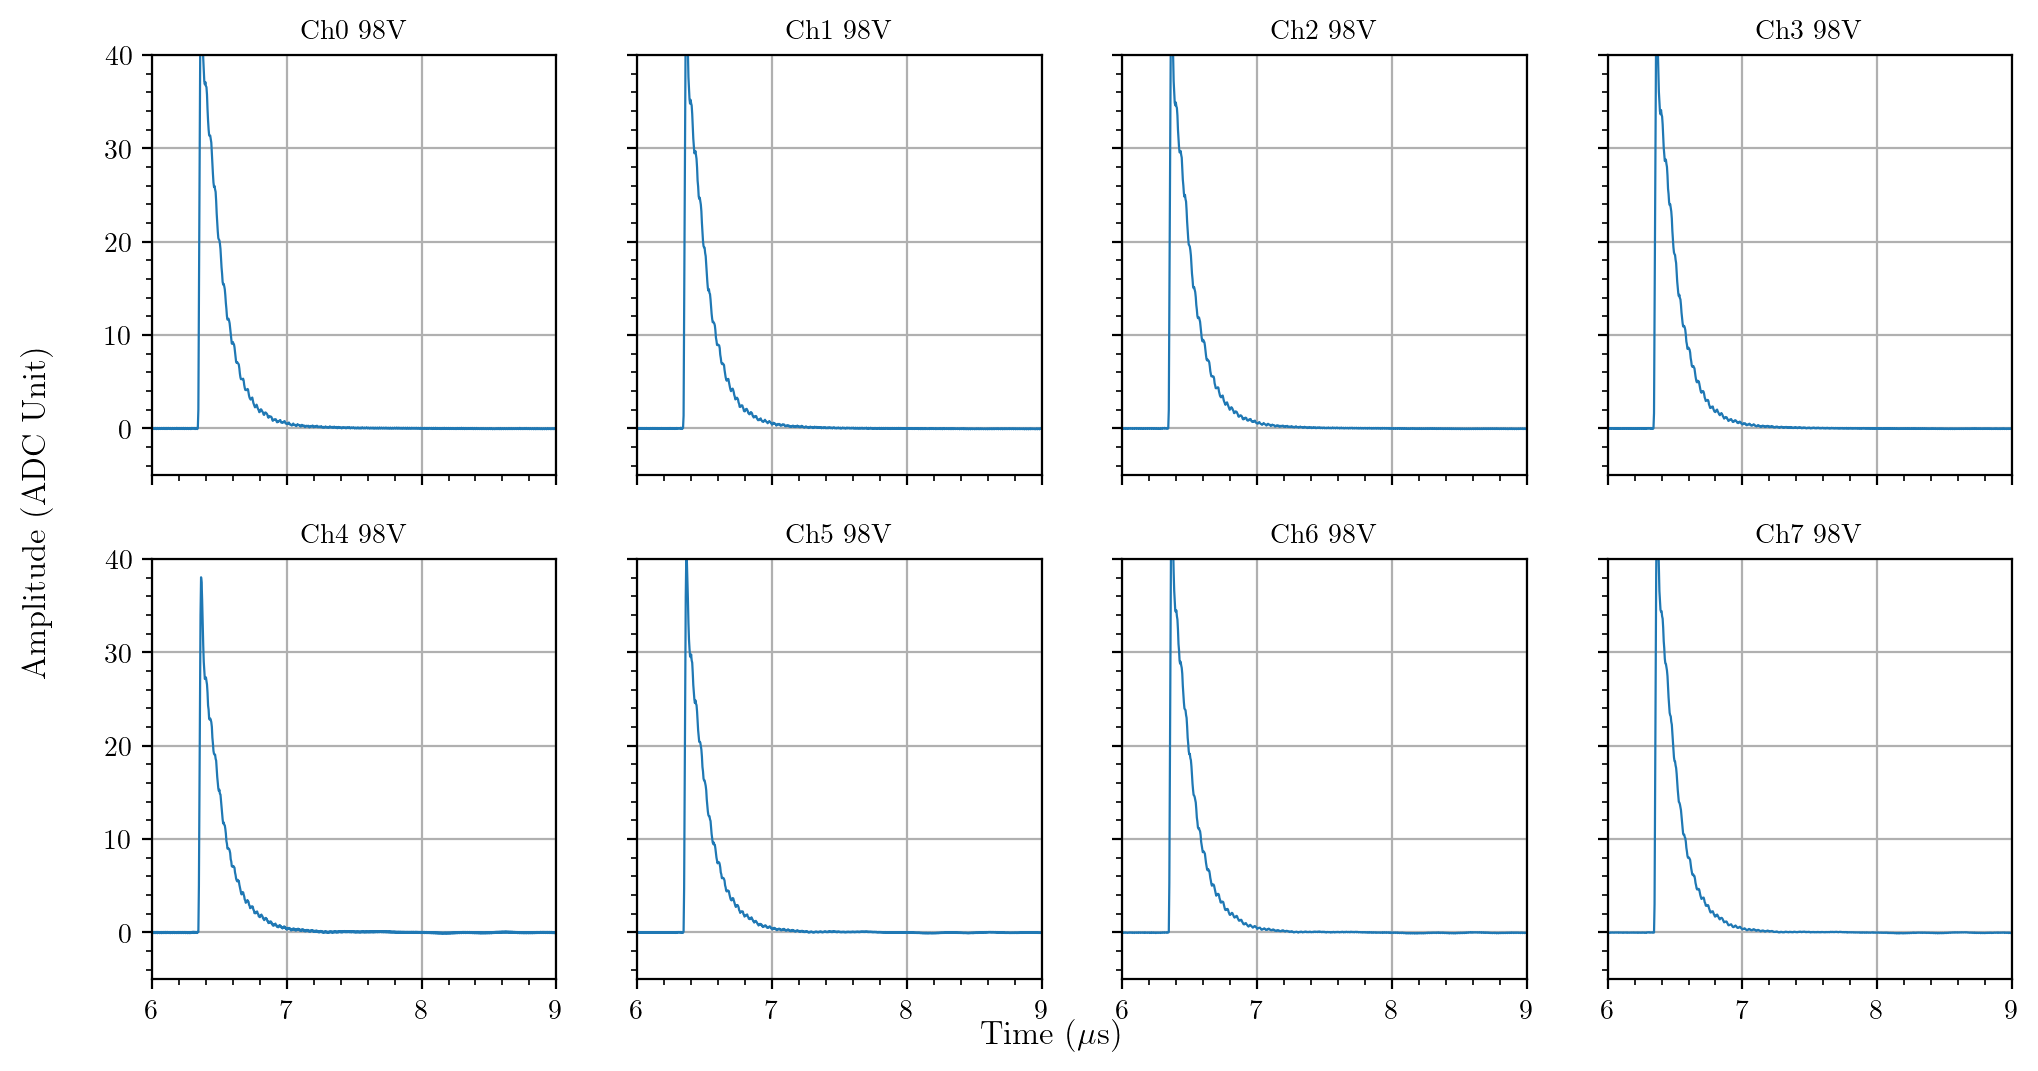

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    if data_spe[ch]['n_spe_wfs']>0:
        print(f'ch{ch} {volt}V {data_spe[ch]["n_spe_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_spe[ch]['time'],
            data_spe[ch]['avg_spe_wf'],linewidth=0.8)
    axs[j//4, j%4].set_xlim(6, 9)
    axs[j//4, j%4].set_ylim(-5, 40)
    # axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

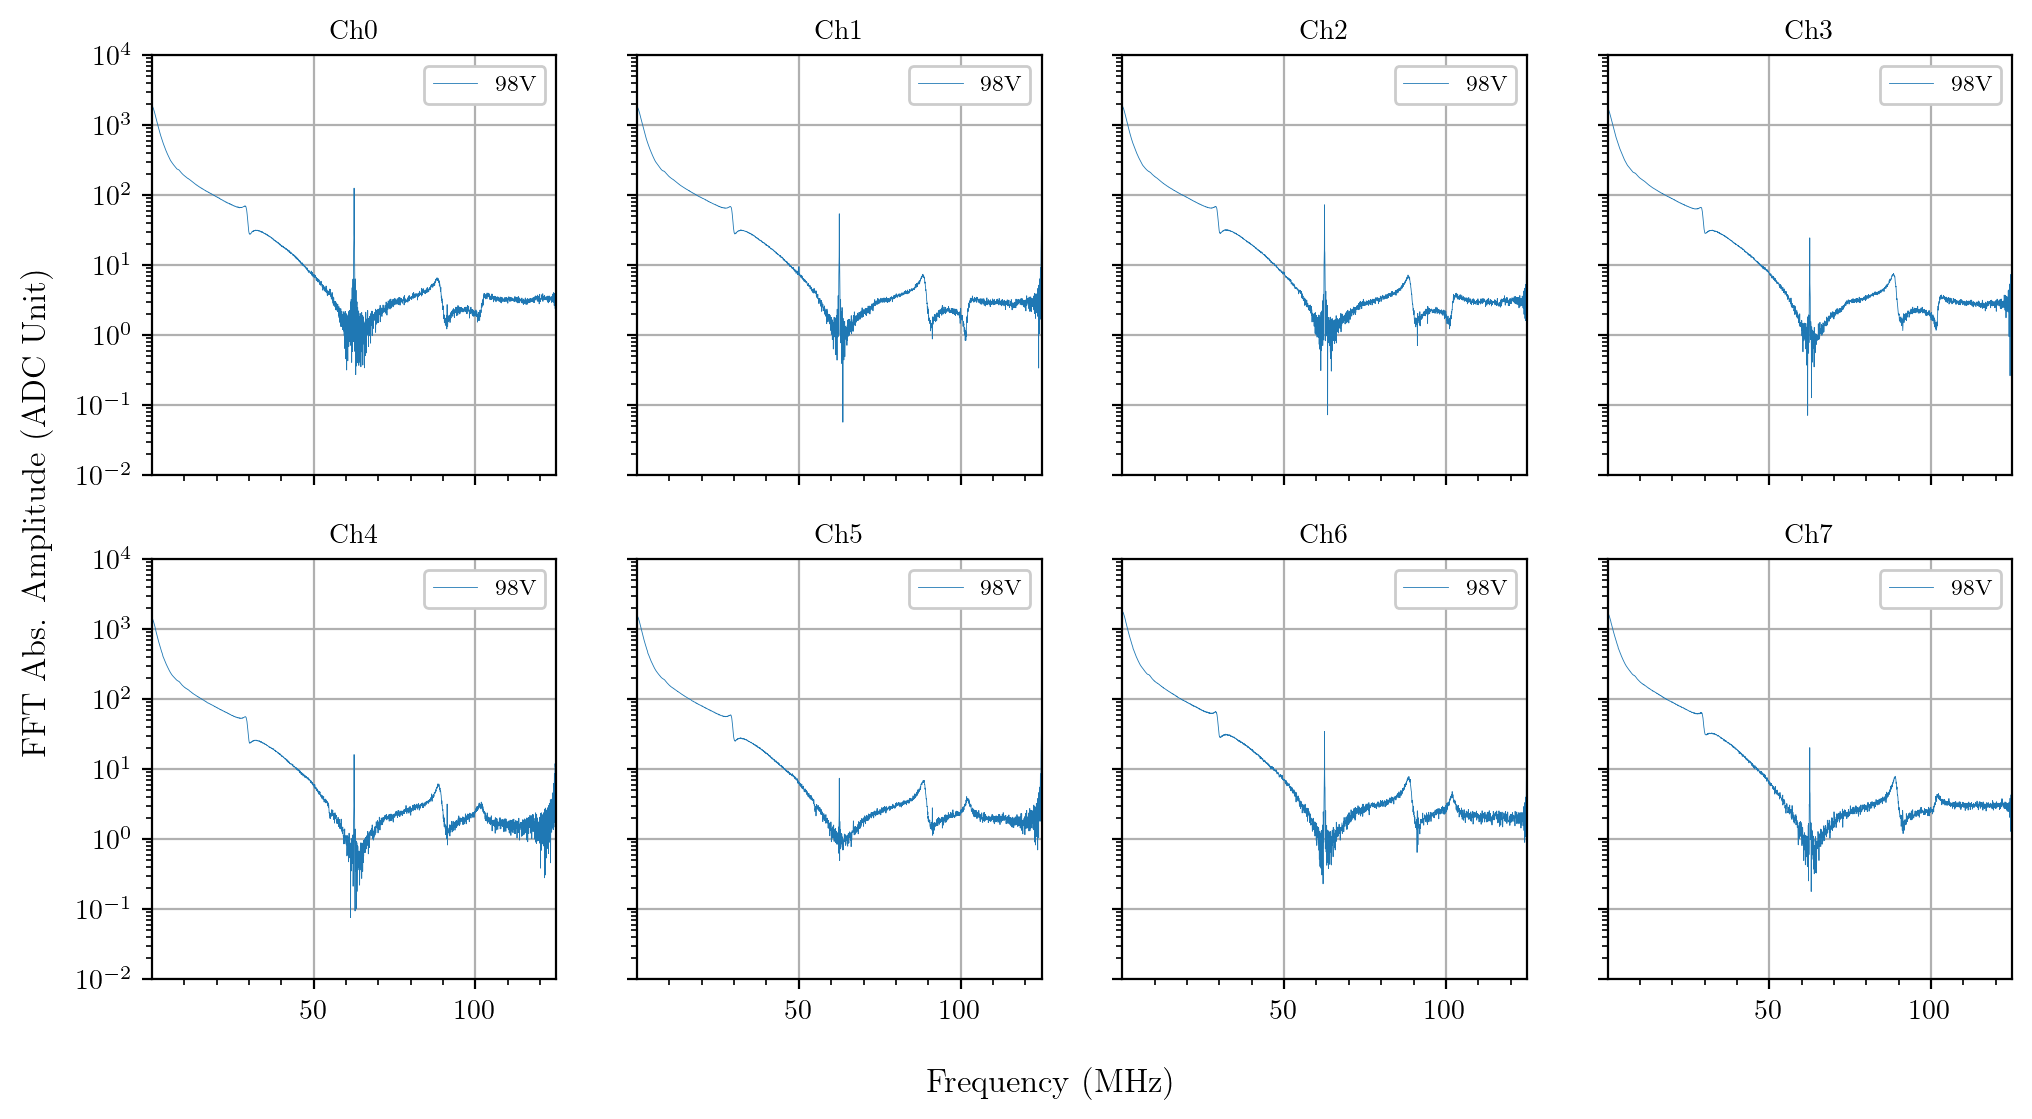

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    data_spe[ch]['fft_spe_wf'] = fft(data_spe[ch]['avg_spe_wf'])
    dt = data_spe[ch]['time'][1]-data_spe[ch]['time'][0]
    t_total = dt+data_spe[ch]['time'][-1]
    n_over_2 = int(data_spe[ch]['time'].shape[0]/2)
    data_spe[ch]['frequency'] = data_spe[ch]['time']/dt/t_total
    axs[j//4, j%4].plot(
        data_spe[ch]['frequency'][:n_over_2],
        abs(data_spe[ch]['fft_spe_wf'][:n_over_2]),
        label=f'{volt}V', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right')
    axs[j//4, j%4].set_xlim(data_spe[ch]['frequency'][1], data_spe[ch]['frequency'][n_over_2])
    axs[j//4, j%4].set_ylim(1e-2, 1e4)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [6]:
def template(t, a_1, tau_1, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0)

In [7]:
# Fit SPE average waveform
for j, ch in enumerate(channels):
    pretrg = 5 #us
    err = np.std(data_spe[ch]['avg_spe_wf'][data_spe[ch]['time']<pretrg])
    fit_range = [6.2,7.5] #us
    range_arr = (data_spe[ch]['time']<fit_range[1])&(data_spe[ch]['time']>fit_range[0])
    # print(pos,ch,volt)
    # print(data_spe[pos][ch][volt]['time'][range_arr])
    # print(data_spe[pos][ch][volt]['avg_spe_wf'][range_arr])
    popt,pcov = curve_fit(
        template,
        data_spe[ch]['time'][range_arr], 
        data_spe[ch]['avg_spe_wf'][range_arr], 
        p0=[20, 0.15, 0.005, 6.35], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
    data_spe[ch]['pars'] = popt
    data_spe[ch]['cov'] = pcov
    print(popt)

[5.18882743e+01 1.45652187e-01 5.24822755e-03 6.35197886e+00]
[4.89816504e+01 1.47975857e-01 5.04287800e-03 6.35189741e+00]
[4.85542993e+01 1.51878563e-01 4.94892909e-03 6.35147961e+00]
[4.73832736e+01 1.47520794e-01 5.00433097e-03 6.35165182e+00]
[3.85683043e+01 1.47689731e-01 4.80248889e-03 6.35362990e+00]
[4.15716795e+01 1.46750985e-01 4.89224968e-03 6.35379402e+00]
[4.82421692e+01 1.46867383e-01 5.04640953e-03 6.35411272e+00]
[4.85213927e+01 1.40289918e-01 5.07136632e-03 6.35516146e+00]


# Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [8]:
def subsample(input_t,input_wf,nsub):
    ntot = int(input_t.shape[0]//nsub * nsub)
    new_t, new_wf = np.zeros(ntot//nsub), np.zeros(ntot//nsub)
    for i in range(nsub):
        new_t += input_t[i:ntot:nsub]
        new_wf += input_wf[i:ntot:nsub]
    new_t /= nsub
    new_wf /= nsub
    return new_t, new_wf

In [9]:
S_PER_HR = 3600
# dt_getter = datetime(2024,4,18,15,43,0)
# print('The getter was turned on at', dt_getter)

dt_xe1 = datetime(2024,5,9,14,30,0)
print('Xenon injection #1 at', dt_xe1)

dt_xe2 = datetime(2024,5,16,10,44,0)
print('Xenon injection #2 at', dt_xe2)

dt_xe3 = datetime(2024,5,16,18,24,0)
print('Xenon injection #3 at', dt_xe3)

# dt_xe4 = datetime(2024,3,19,15,0,0)
# print('Xenon injection #4 at', dt_xe4)

# dt_xe5 = datetime(2024,3,25,20,0,0)
# print('Xenon injection #5 at', dt_xe5)

Xenon injection #1 at 2024-05-09 14:30:00
Xenon injection #2 at 2024-05-16 10:44:00
Xenon injection #3 at 2024-05-16 18:24:00


In [11]:
# Pure LAr
# path = "/scratch/gpfs/as111/results/"
# dates = ['2024-04-19','2024-04-26']
# files = []
# for d in dates:
#     files.extend(glob.glob(f"{path}{d}/*xenon_0*scintillation_waveform_liq7.h5"))
# for i,f in enumerate(files):
#     files[i] = [files[i]]
# print(files)
# print(len(files))

# Xe injection monitoring
path = "/scratch/gpfs/as111/results/"
dates = ['2024-05-09', # injection #1
         '2024-05-16', # injection #2 #3
        #  '2024-03-19', # injection #4
        #  '2024-03-25'  # injection #5
        ]
files = []
for d in dates:
    files.extend(glob.glob(f"{path}{d}/*cond_monitor*scintillation_waveform_liq7.h5"))
for i,f in enumerate(files):
    files[i] = [files[i]]
print(files)
print(len(files))

[['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run28_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run10_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run26_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run0_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run2_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run4_scintillation_waveform_liq7.h5'], ['/scratch/gpfs/as111/results/2024-05-09/2024-05-09_volt_98_light_scintillation_cond

In [12]:
# data folder
data_scint = {}
date_time = {}
channels = np.arange(8)
channels_nofs = [1,2,4,7] 
channels_fs = [0,3,5,6]
ch_old = [0,5,6,3,4,1,2,7] # map to channels in liq5 calibration data
volt = 98
for i,fs in enumerate(files):
    data_scint[i] = {}
    for j,f in enumerate(fs):
        df = pd.read_hdf(f, key=f'{volt}/-1')
        if j==0:
            date_time[i] = datetime(*np.array(df['start_datetime'][:6]).astype(int))
        for ch in channels:
            if j==0:
                data_scint[i][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data_scint[i][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
            if data_scint[i][ch]['time'].shape[0]==0:
                data_scint[i][ch]['time'] = np.array(df['time'].dropna())
            if data_scint[i][ch]['avg_scint_wf'].shape[0]==0:
                data_scint[i][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            else:
                data_scint[i][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[i][ch]['avg_scint_wf'] /= data_scint[i][ch]['n_scint_wfs']
# sort according to date time
args = np.array(list(date_time.values())).argsort()
files = [files[i] for i in args]
data_scint = [data_scint[i] for i in args]
date_time = [date_time[i] for i in args]
hr_from_inject = [(dt-dt_xe1).total_seconds()/S_PER_HR for dt in date_time]
# hr_from_getter = [(dt-dt_getter).total_seconds()/S_PER_HR for dt in date_time]

2024-05-09 13:41:44 ch0 9146 waveforms selected
2024-05-09 16:45:08 ch0 9730 waveforms selected
2024-05-09 19:48:28 ch0 9815 waveforms selected
2024-05-09 22:51:46 ch0 9830 waveforms selected
2024-05-10 01:55:06 ch0 9823 waveforms selected
2024-05-10 04:58:30 ch0 9730 waveforms selected
2024-05-10 08:01:47 ch0 9891 waveforms selected
2024-05-10 11:05:05 ch0 9754 waveforms selected
2024-05-10 14:08:26 ch0 9690 waveforms selected
2024-05-10 17:11:46 ch0 9749 waveforms selected
2024-05-10 20:15:04 ch0 9718 waveforms selected
2024-05-10 23:18:22 ch0 9590 waveforms selected
2024-05-11 02:21:42 ch0 9745 waveforms selected
2024-05-11 05:25:04 ch0 9825 waveforms selected
2024-05-11 08:28:27 ch0 9720 waveforms selected
2024-05-11 11:31:47 ch0 9693 waveforms selected
2024-05-11 14:35:06 ch0 9891 waveforms selected
2024-05-11 17:38:28 ch0 9827 waveforms selected
2024-05-11 20:41:46 ch0 9837 waveforms selected
2024-05-11 23:45:06 ch0 9850 waveforms selected
2024-05-12 02:48:25 ch0 9726 waveforms s

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

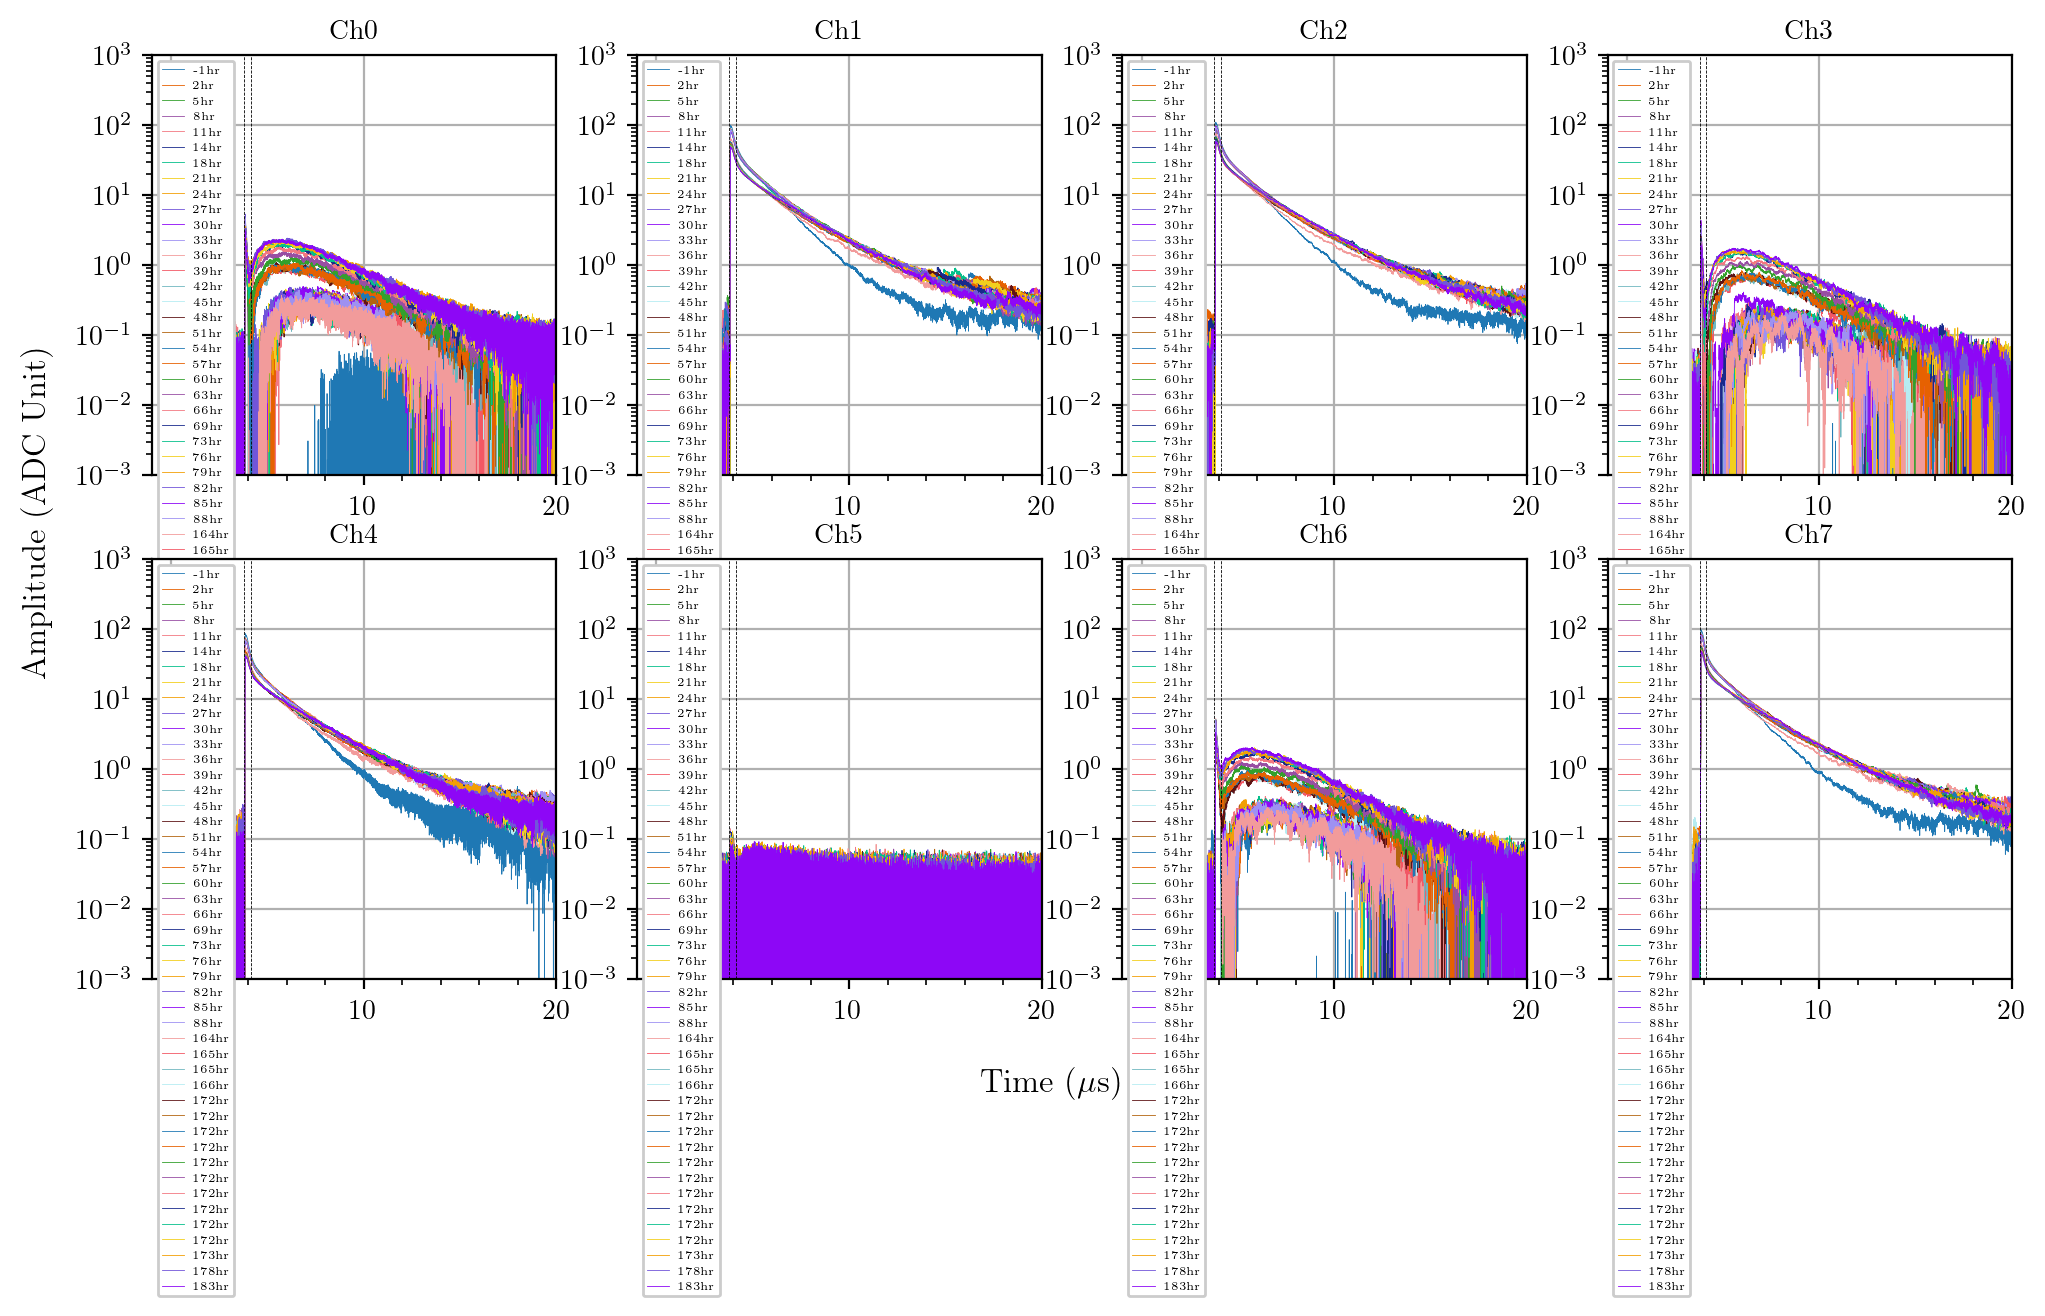

In [13]:
# Make plots for all datasets
# Average LAr scintillation waveform
t_trig = 3.82
ylims = (1e-3,1e3)
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files):
        print(f'{date_time[k]} ch{ch} {data_scint[k][ch]["n_scint_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_scint[k][ch]['time'],
            data_scint[k][ch]['avg_scint_wf'],
            # label=f'{hr_from_getter[k]:.0f}hr', color=f'C{k}', linewidth=0.3)
            label=f'{hr_from_inject[k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper left',fontsize=4)
    axs[j//4, j%4].set_xlim(-1, 20)
    axs[j//4, j%4].set_ylim(*ylims)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
    axs[j//4, j%4].plot([t_trig-10*0.004]*2, ylims, 'k--',linewidth=0.3)
    axs[j//4, j%4].plot([t_trig+0.3]*2, ylims, 'k--',linewidth=0.3)
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [14]:
# Deconvolution channel by channel
for i, f in enumerate(files):
    for j, ch in enumerate(channels):
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch_old[ch]]['n_spe_wfs']>0:
            dt = data_spe[ch_old[ch]]['time'][1]-data_spe[ch_old[ch]]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[ch_old[ch]]['pars'][3]/dt))) for freq in data_spe[ch_old[ch]]['frequency']])
            data_scint[i][ch]['deconv'] = ifft(fft(data_scint[i][ch]['avg_scint_wf'])/data_spe[ch_old[ch]]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

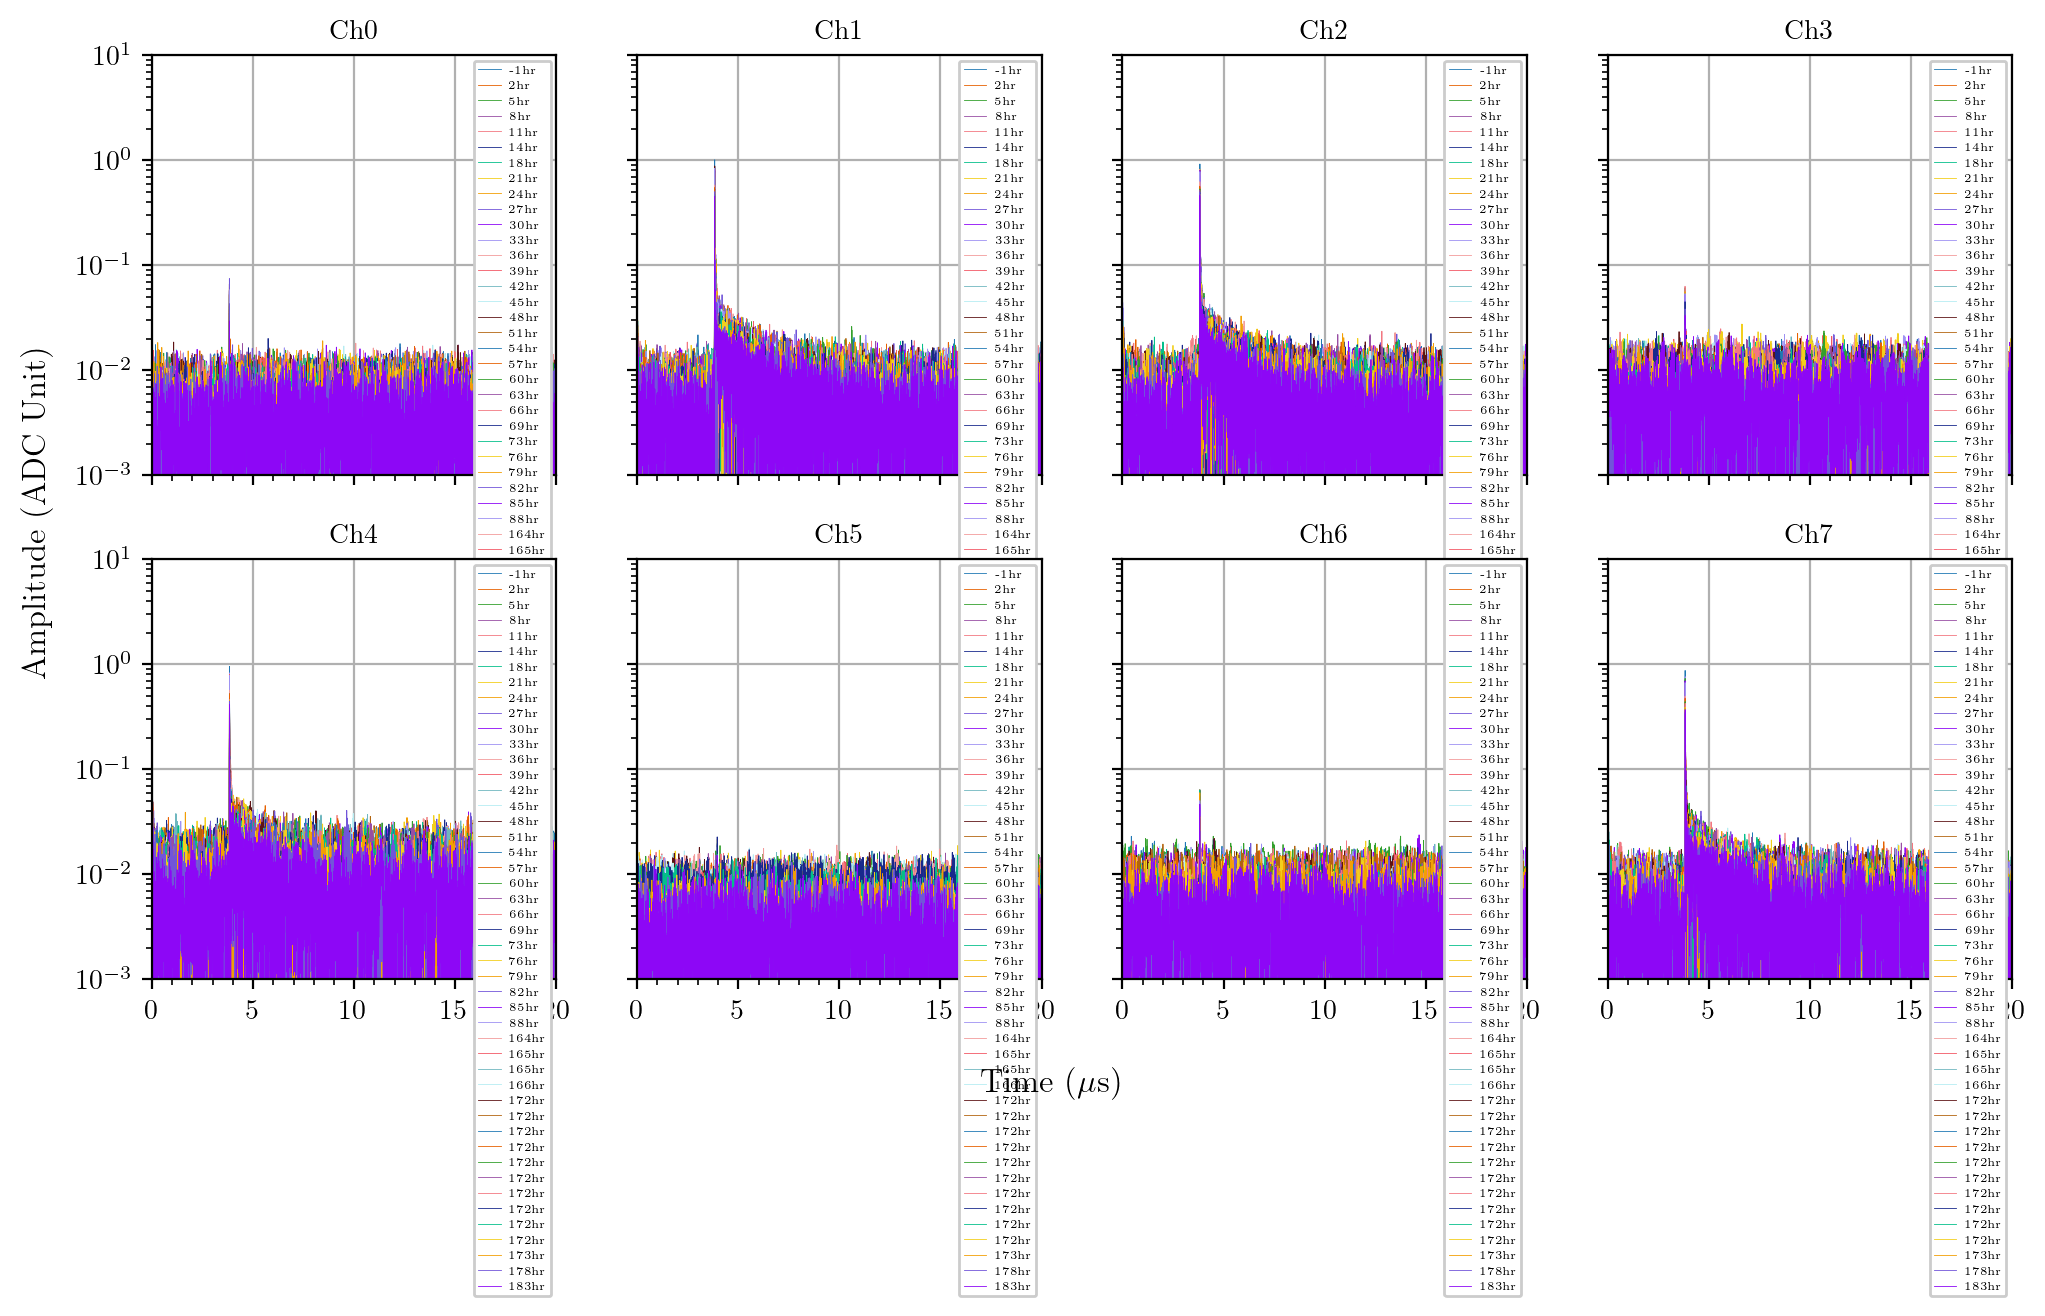

In [15]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files):
        if data_scint[k][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            axs[j//4, j%4].plot(
                data_scint[k][ch]['time'],
                abs(data_scint[k][ch]['deconv']),
                # label=f'{hr_from_getter[-12+k]:.0f}hr', color=f'C{k}', linewidth=0.3)
                label=f'{hr_from_inject[k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right', fontsize=4)
    axs[j//4, j%4].set_xlim(0, 20)
    axs[j//4, j%4].set_ylim(1e-3, 1e1)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation + Subsampling

In [16]:
# summation
for i,f in enumerate(files):
    data_scint[i][-1] = {'time': data_scint[i][0]['time'], 'sum_wf_nofs': np.zeros(data_scint[i][0]['time'].shape[0]),'sum_wf_fs': np.zeros(data_scint[i][0]['time'].shape[0])}
    for ch in channels_nofs:    
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_nofs'] += data_scint[i][ch]['deconv']
    for ch in channels_fs:
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_fs'] += data_scint[i][ch]['deconv']

In [17]:
# subsampling
nsub = 4
for i,f in enumerate(files):
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_nofs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_nofs'],nsub)
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_fs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_fs'],nsub)

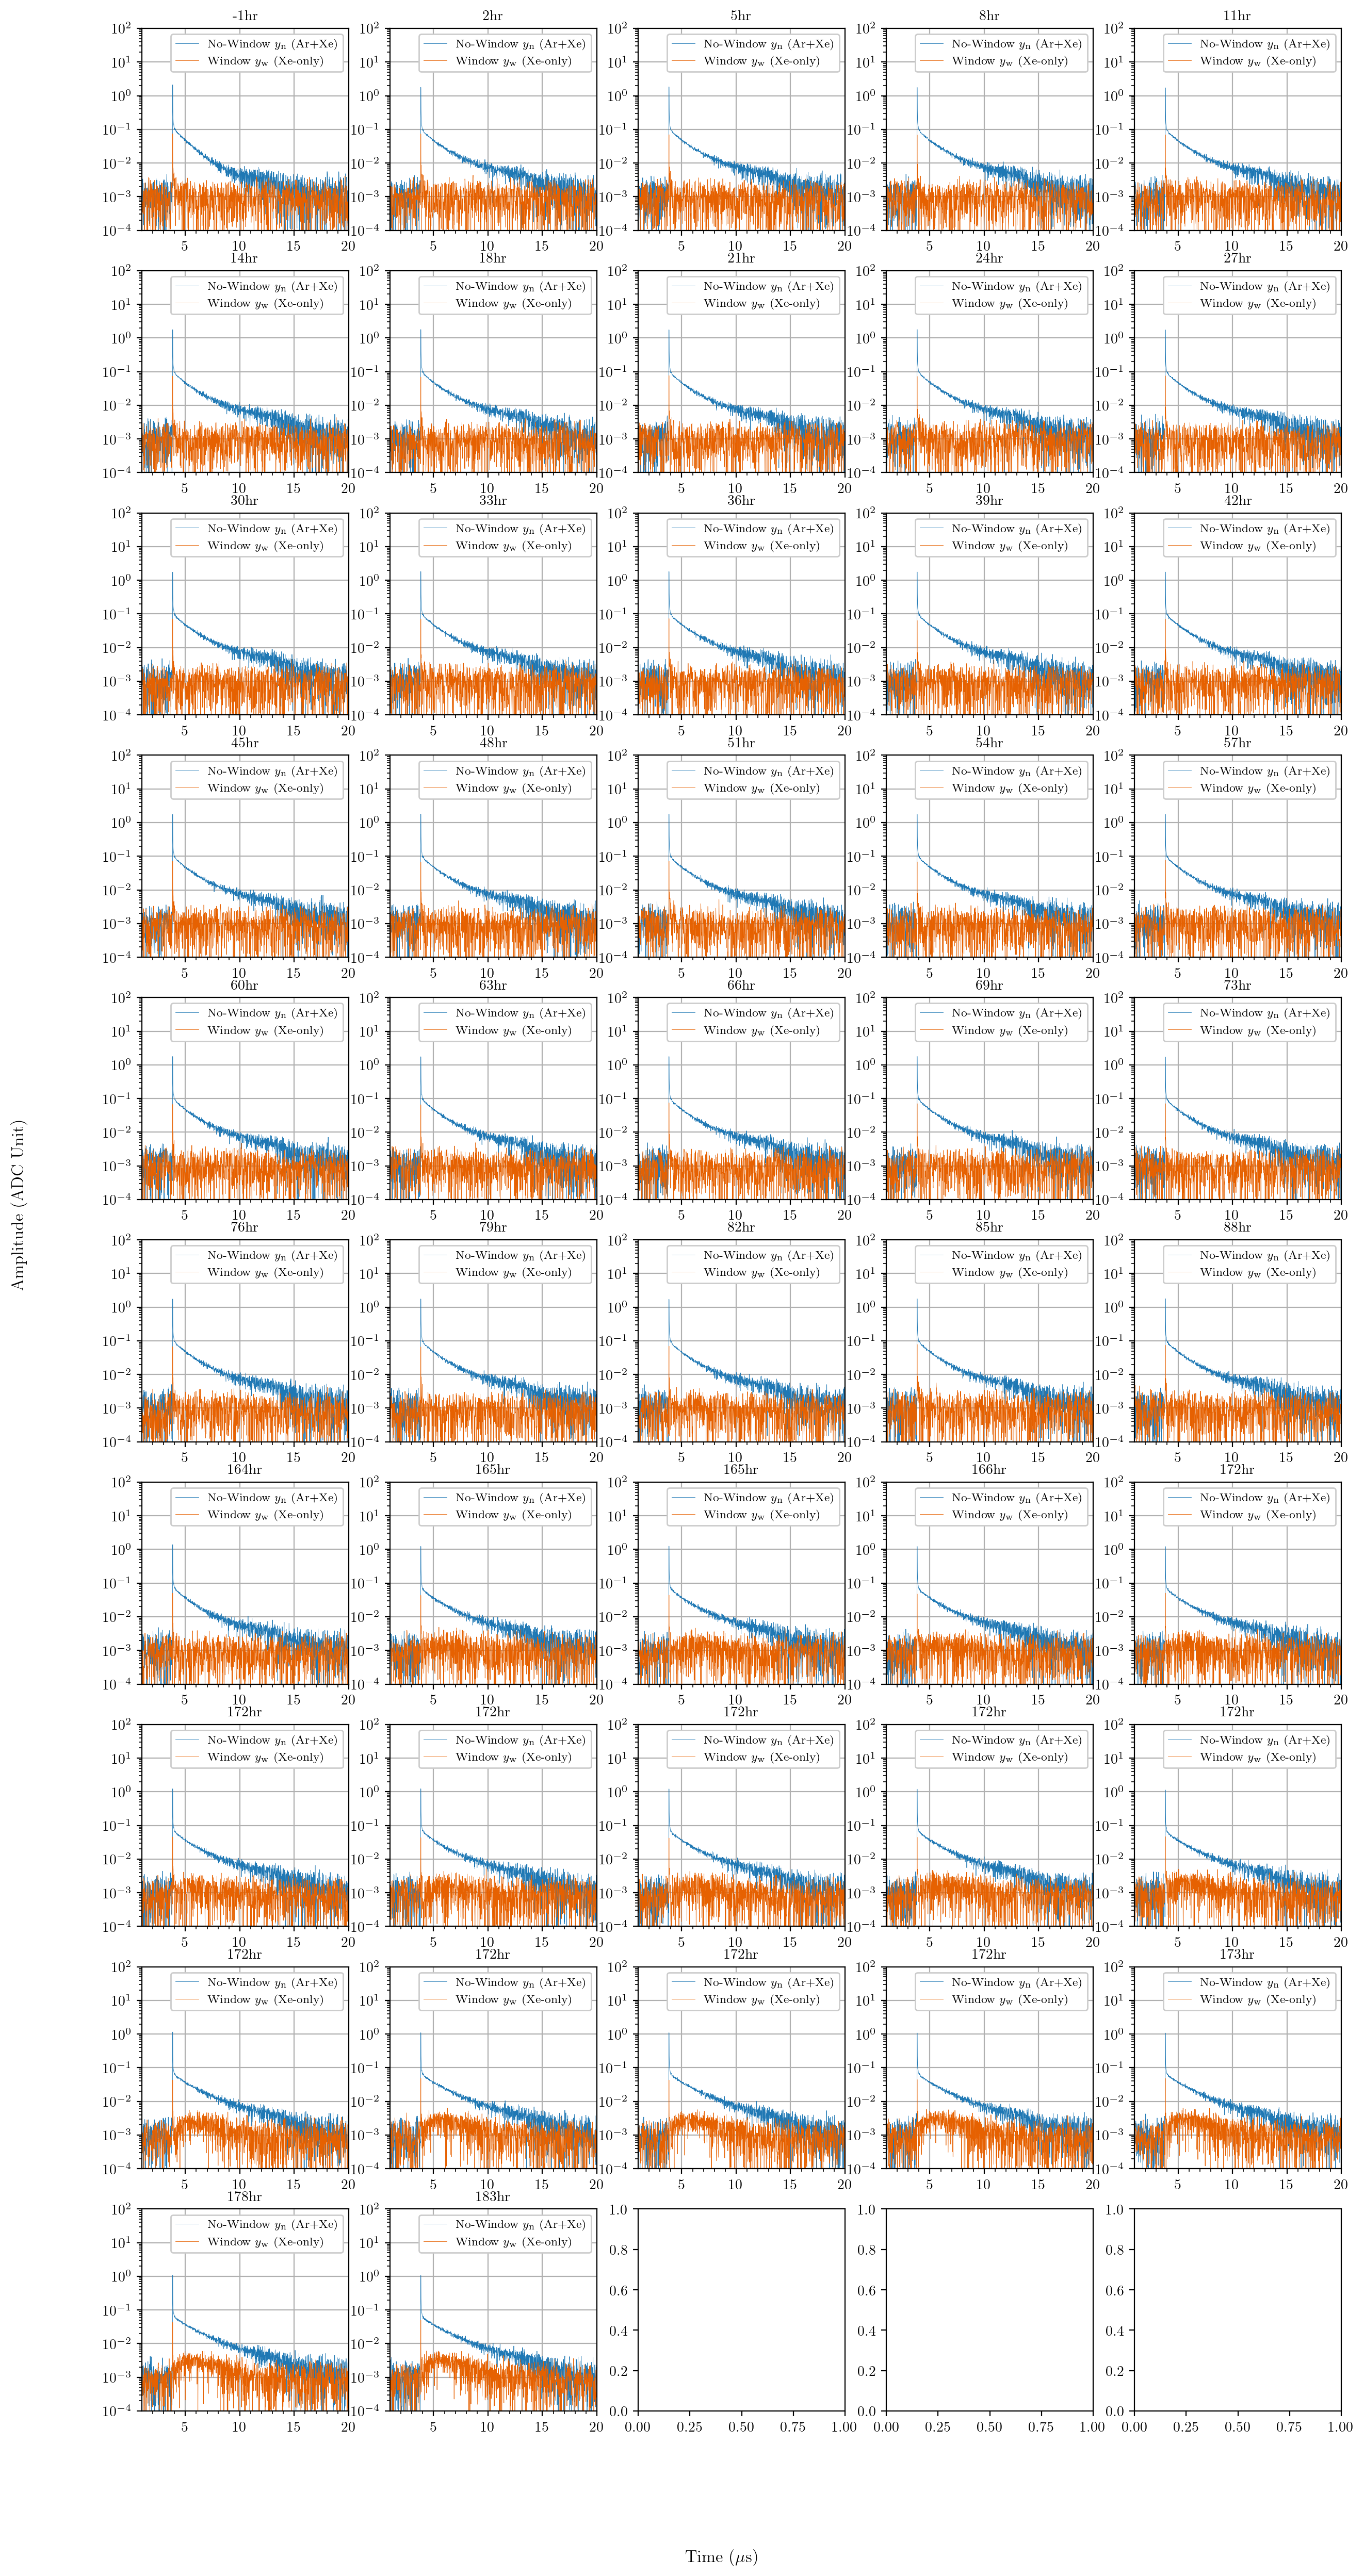

In [18]:
# Make plots for all datasets
# Summed scintillation waveform
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
nofs_total_pe = []
fs_total_pe = []
for i, f in enumerate(files):
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_nofs']),
                linewidth=0.3,label=r'No-Window $y_{\rm n}$ (Ar+Xe)')
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_fs']),
                linewidth=0.3, label=r'Window $y_{\rm w}$ (Xe-only)')
    axs[i//5, i%5].set_xlim(1, 20)
    axs[i//5, i%5].set_ylim(1e-4, 1e2)
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
    # axs[i//5, i%5].set_title(f'{hr_from_getter[i]:.0f}hr')
    axs[i//5, i%5].legend(loc='upper right')
    nofs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_nofs'])*nsub)
    fs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_fs'])*nsub)
fig.supxlabel(r'Time ($\mu$s)', y=0.06)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.04)
nofs_total_pe = np.array(nofs_total_pe)
fs_total_pe = np.array(fs_total_pe)

In [19]:
# def template4(t,a1,tau1,a2,tau2):
#     t = t-6.22
#     return a1/tau1*np.exp(-t/tau1) + a2/(tau2-tau1)*(np.exp(-t/tau2)-np.exp(-t/tau1))

In [20]:
# for i in range(10):
#     plt.figure(i,figsize=(3,3))
#     ylims = (1e-3,1e1)
#     y = data_scint[i][-1]['sum_wf_sub_nofs'] - 1.32*data_scint[i][-1]['sum_wf_sub_fs']
#     plt.plot(
# 		data_scint[i][-1]['time_sub'],
# 		abs(y),
# 		linewidth=0.3,label=r'No-Window $y_{\rm n}$ (Ar+Xe)')
    
#     t_arr = np.linspace(6.22,16,200)
#     a1, tau1, a2, tau2 = 0.13,1,0.2,3
#     fit_range = [6.6,13] #us
#     pretrg = 5.0
#     range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
#     err = np.std(y[data_scint[i][-1]['time_sub']<pretrg])
#     popt,pcov = curve_fit(
# 		template4,
# 		data_scint[i][-1]['time_sub'][range_arr],
# 		y[range_arr], 
# 		p0=[a1,tau1,a2,tau2], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
    
#     plt.plot(t_arr, template4(t_arr,*popt),'r--',linewidth=0.6)
#     plt.plot([fit_range[0]]*2,ylims,'k--',linewidth=0.6)
#     plt.plot([fit_range[1]]*2,ylims,'k--',linewidth=0.6)
#     plt.title('{:.3f} {:.3f} {:.3f} {:.3f}'.format(*popt))
    
#     plt.grid()
#     plt.minorticks_on()
#     plt.legend(loc='upper right')
#     plt.yscale('log')
#     plt.ylim(*ylims)
#     plt.xlim(6,16)

## Fitting

In [21]:
# def template2(t, a_1, tau_1, a_2, tau_2, sigma, t0):
#         return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [22]:
def template3(t,a,tau,trig=6.22):
    return a/tau*0.004*np.exp(-(t-trig)/tau)

In [23]:
class LArXePulseShape():
    def __init__(self, xe_pulse, t_trig):
        """_summary_

        Args:
            xe_pulse (tuple): xe_pulse = [time_array, amplitude_array] for xenon-only pulse
        """
        self.t_arr = xe_pulse[0]
        self.xe_pulse_y = xe_pulse[1]
        self.t_trig = t_trig

    def get_pulse_model(self, a, tau, a_xe=1.33):
        t = self.t_arr-self.t_trig
        pulse_model = a/tau*0.004*np.exp(-t/tau) + a_xe*self.xe_pulse_y # sample interval = 0.004us
        return pulse_model
        
    def fit_to_data(self, data_y, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            a, tau, a_xe = x[0], x[1], x[2]
            ar_xe_pulse = args
            ans = (ar_xe_pulse-self.get_pulse_model(a, tau, a_xe))
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (self.t_arr<fit_range[1]) & (self.t_arr>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data_y,bounds=(0,np.inf))
        cov = np.linalg.inv(res.jac.T@res.jac)
        return res.x, cov
        

In [24]:
# Fit SPE average waveform
data_sub = {}
t_trig = 3.82
for i,f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        pretrg = 3.5 #us
        # simple exponential fit to windowless
        fit_range = [4.5,8.2] #us
        # windowed + simple exponential fit to windowless
        # fit_range = [6.35,10] #us
        err = np.std(data_scint[i][-1]['sum_wf_sub_nofs'][data_scint[i][-1]['time_sub']<pretrg])
        
        # simple exponential fit to windowless
        range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
        popt,pcov = curve_fit(
            template3,
            data_scint[i][-1]['time_sub'][range_arr], 
            data_scint[i][-1]['sum_wf_sub_nofs'][range_arr], 
            p0=[100,1], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        
        # windowed + simple exponential fit to windowless
        # ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'],data_scint[i][-1]['sum_wf_sub_fs']/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub), t_trig=t_trig)
        # popt, pcov = ar_xe_pulse_fit.fit_to_data(data_scint[i][-1]['sum_wf_sub_nofs'],sigma=err*np.ones_like(data_scint[i][-1]['time_sub']),x0=[50,0.6,30],fit_range=fit_range)
        
        data_scint[i][-1]['pars'] = popt
        data_scint[i][-1]['cov'] = pcov
        data_scint[i][-1]['pars_err'] = np.array([func.error_distance(df=2, sigma=1)*pcov[j,j]**0.5 for j in range(len(popt))])
        data_scint[i][-1]['fit_range'] = fit_range
        
        # windowed + simple exponential fit to windowless
        # print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us A_Xe = {popt[2]:.3f}+/-{data_scint[i][-1]["pars_err"][2]:.3f}')

        # simple exponential fit to windowless
        print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us')
        

2024-05-09 13:41:44 A=8.76+/-0.22 tau=1.587+/-0.024us
2024-05-09 16:45:08 A=13.22+/-0.33 tau=2.044+/-0.035us
2024-05-09 19:48:28 A=13.68+/-0.35 tau=2.047+/-0.036us
2024-05-09 22:51:46 A=13.37+/-0.34 tau=2.049+/-0.036us
2024-05-10 01:55:06 A=13.07+/-0.32 tau=2.050+/-0.034us
2024-05-10 04:58:30 A=13.30+/-0.34 tau=2.042+/-0.036us
2024-05-10 08:01:47 A=13.71+/-0.34 tau=2.054+/-0.035us
2024-05-10 11:05:05 A=13.44+/-0.33 tau=2.056+/-0.035us
2024-05-10 14:08:26 A=13.66+/-0.30 tau=2.055+/-0.031us
2024-05-10 17:11:46 A=13.30+/-0.32 tau=2.053+/-0.034us
2024-05-10 20:15:04 A=13.40+/-0.34 tau=2.042+/-0.036us
2024-05-10 23:18:22 A=13.34+/-0.34 tau=2.030+/-0.035us
2024-05-11 02:21:42 A=13.96+/-0.34 tau=2.073+/-0.035us
2024-05-11 05:25:04 A=13.30+/-0.33 tau=2.047+/-0.035us
2024-05-11 08:28:27 A=13.41+/-0.33 tau=2.050+/-0.034us
2024-05-11 11:31:47 A=13.35+/-0.33 tau=2.034+/-0.035us
2024-05-11 14:35:06 A=13.39+/-0.31 tau=2.029+/-0.033us
2024-05-11 17:38:28 A=13.62+/-0.34 tau=2.058+/-0.036us
2024-05-11 

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

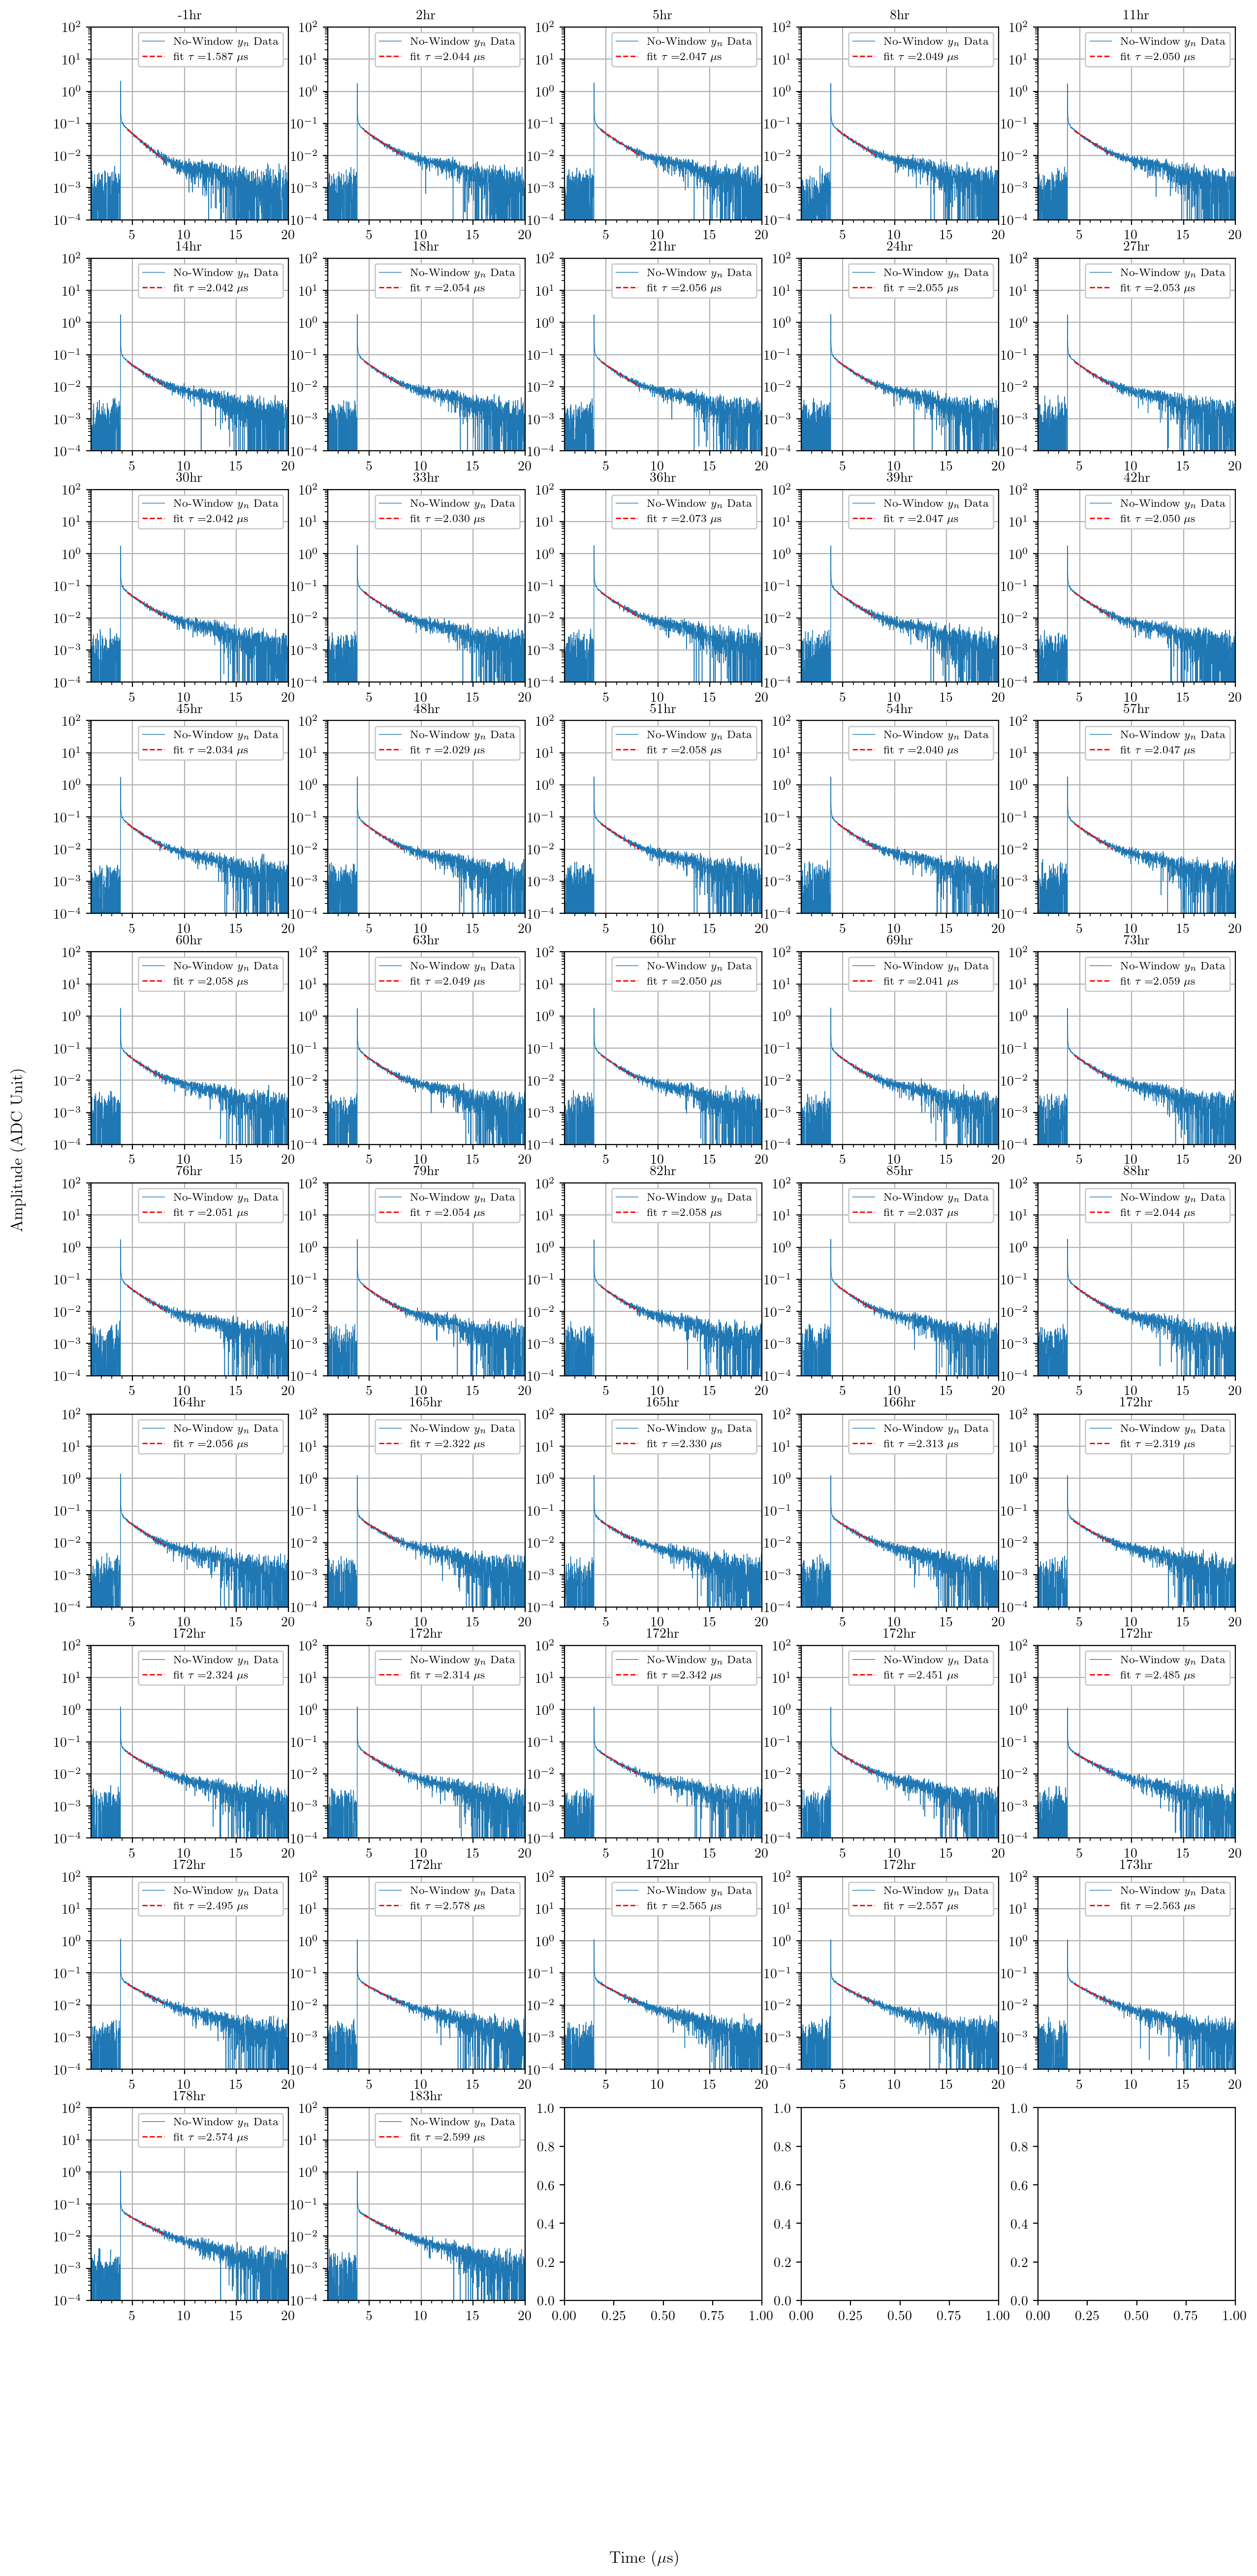

In [25]:
# Make plots for all datasets
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'],
            data_scint[i][-1]['sum_wf_sub_nofs'],
            label=r'No-Window $y_n$ Data', color='C0', linewidth=0.5)
        mask = (data_scint[i][-1]['time_sub']>data_scint[i][-1]['fit_range'][0]) & (data_scint[i][-1]['time_sub']<data_scint[i][-1]['fit_range'][1])
        
        # simple exponential fit to windowless
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            template3(data_scint[i][-1]['time_sub'][mask], *data_scint[i][-1]['pars']),
            label=r'fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='r', linestyle='--', linewidth=1)
        
        # windowed + simple exponential fit to windowless
        # ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'][mask],data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub),t_trig=t_trig)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars']),
        #     label=r'No-Window $y_n$ Fit', color='C1', linestyle='-', linewidth=1)
        #     # label=r'No FS fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='C1', linestyle='-', linewidth=1)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars'][:-1], a_xe=0),
        #     label=r'Ar-only', color='C2', linestyle='--', linewidth=1)
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     data_scint[i][-1]['pars'][-1]*data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub,
        #     label=r'Xe-only', color='C3', linestyle='--', linewidth=1)
        
        axs[i//5, i%5].legend(loc='upper right',ncol=1)
        axs[i//5, i%5].set_xlim(1, 20)
        axs[i//5, i%5].set_ylim(1e-4, 1e2)
        axs[i//5, i%5].set_yscale('log')
        axs[i//5, i%5].minorticks_on()
        axs[i//5, i%5].grid()
        axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
        # axs[i//5, i%5].set_title(f'{hr_from_getter[i]:.0f}hr')
fig.supxlabel(r'Time ($\mu$s)', y=0.02)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

# Triplet lifetime evolution

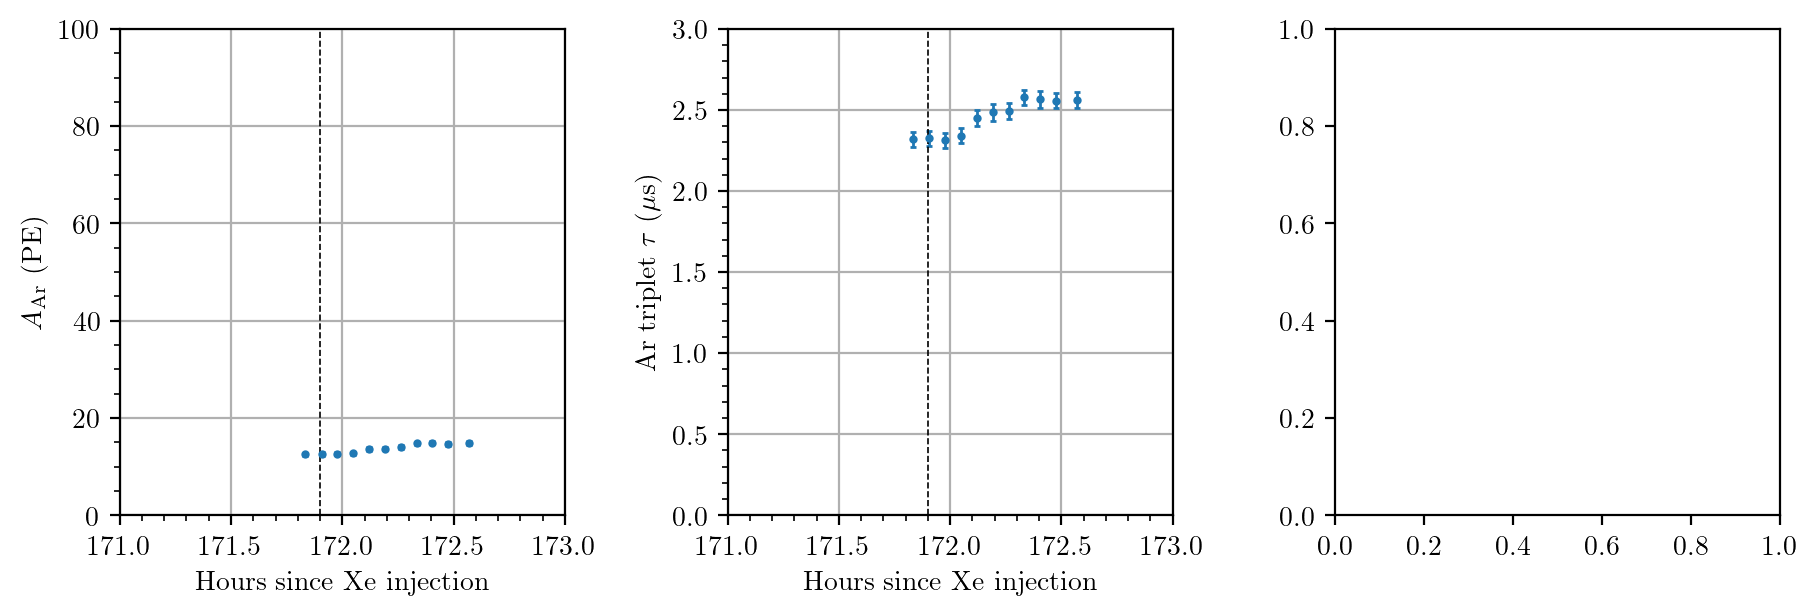

In [32]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=False)
fig.set_size_inches(9, 3)
fig.tight_layout(h_pad=3, w_pad=3)

ylabels = [r'$A_{\rm Ar}$ (PE)', r'Ar triplet $\tau$ ($\mu$s)', r'$A_{\rm Xe} (PE)$']
ylims = [(0,100),(0,3),(0,100)]

for i in range(2):
    axs[i].errorbar(
        hr_from_inject,
        # hr_from_getter,
        [data_scint[j][-1]['pars'][i] for j in range(len(files))],
        yerr=[func.error_distance(df=2, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][i,i]) for j in range(len(files))],
        linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
    )
    axs[i].plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    axs[i].plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    # axs[i].plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    # axs[i].plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_ylim(*ylims[i])
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_xlim(171,173)
    # axs[i].set_xlabel('Hours since getter on')
    axs[i].set_xlabel('Hours since Xe injection')

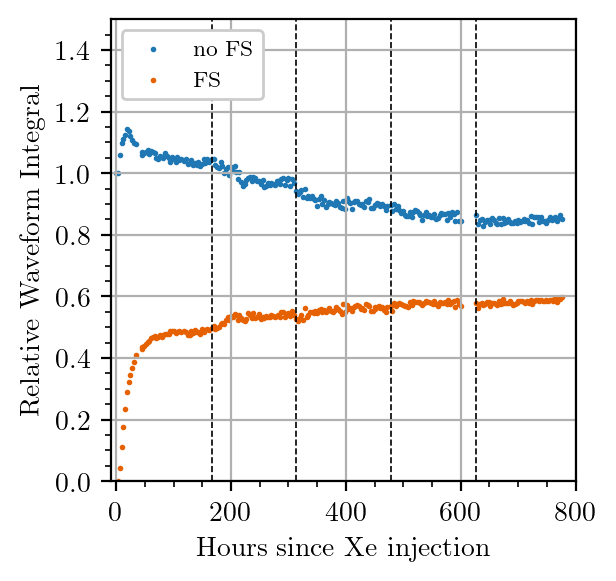

In [26]:
ylims = (-0,1.5)
plt.figure(0,figsize=(3,3))
plt.scatter(
    hr_from_inject,
	nofs_total_pe/nofs_total_pe[0],
	label='no FS', s=1
)
plt.scatter(
    hr_from_inject,
	fs_total_pe/nofs_total_pe[0],
	label='FS', s=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Relative Waveform Integral')
plt.xlabel('Hours since Xe injection')
plt.legend()

Text(0.5, 0, 'Hours since Xe injection')

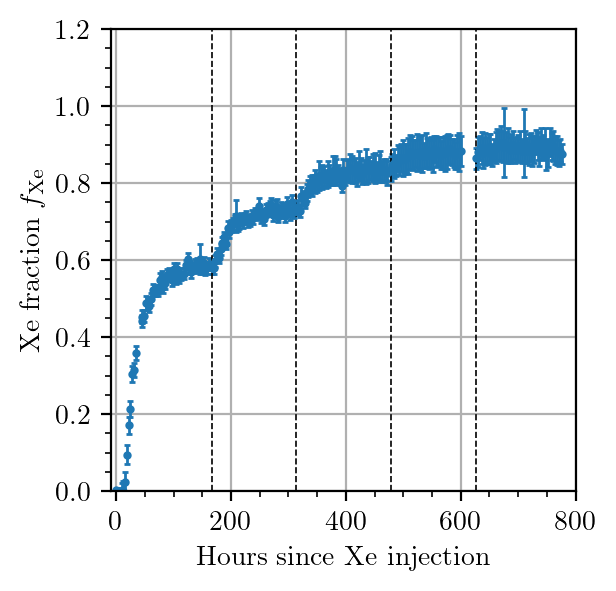

In [27]:
ylims = (0,1.2)
plt.figure(0,figsize=(3,3))
plt.errorbar(
    hr_from_inject,
	np.array([data_scint[j][-1]['pars'][2] for j in range(len(files))])/nofs_total_pe,
	yerr=np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][2,2]) for j in range(len(files))])/nofs_total_pe,
	linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Xe fraction $f_{\rm Xe}$')
plt.xlabel('Hours since Xe injection')

NoFS-to-FS relative efficiency = 1.312+/-0.003+/-0.021


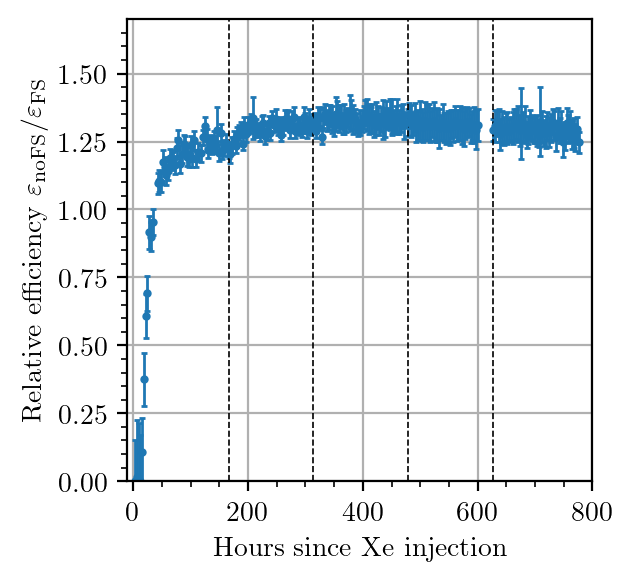

In [28]:
ylims = (0,1.7)
plt.figure(0,figsize=(3,3))
rel_eff = np.array([data_scint[j][-1]['pars'][2] for j in range(len(files))])/fs_total_pe
rel_eff_err = np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][2,2]) for j in range(len(files))])/np.abs(fs_total_pe)
plt.errorbar(
    hr_from_inject,
	rel_eff,
	yerr=rel_eff_err,
	linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,800)
plt.minorticks_on()
plt.ylabel(r'Relative efficiency $\varepsilon_{\rm no FS}/\varepsilon_{\rm FS}$')
plt.xlabel('Hours since Xe injection')
rel_eff_avg, rel_eff_avg_err = np.sum((rel_eff/(rel_eff_err)**2)[np.array(hr_from_inject)>250])/np.sum((rel_eff_err**(-2))[np.array(hr_from_inject)>250]), np.sum(rel_eff_err[np.array(hr_from_inject)>250]**(-2))**(-0.5)
print(f'NoFS-to-FS relative efficiency = {rel_eff_avg:.3f}+/-{rel_eff_avg_err:.3f}+/-{np.std(rel_eff[np.array(hr_from_inject)>250]):.3f}')

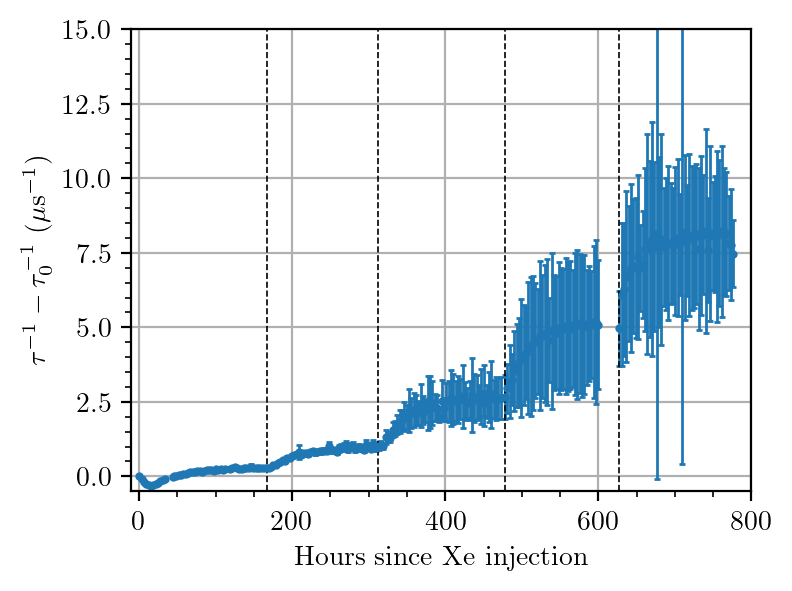

In [29]:
ylims = (-0.5,15)
tau = np.array([data_scint[j][-1]['pars'][1] for j in range(len(files))])
tau_err = np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][1,1]) for j in range(len(files))])
tau0 = data_scint[0][-1]['pars'][1]
tau0_err = func.error_distance(df=2, sigma=1)*np.sqrt(data_scint[0][-1]['cov'][1,1])
n_sigma_v = 1/tau - 1/tau0
n_sigma_v_err = ((tau_err/tau**2)**2 + (tau0_err/tau0**2)**2)**0.5
plt.errorbar(
        hr_from_inject,
        n_sigma_v,
        yerr=n_sigma_v_err,
        linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe3-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe4-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot([(dt_xe5-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.ylabel(r'$\tau^{-1}-\tau_0^{-1}$ ($\rm \mu s^{-1}$)')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,800)
plt.ylim(*ylims)
plt.grid()
plt.minorticks_on()

# AmBe NR vs Co60 ER pulse shape

In [43]:
path = "/scratch/gpfs/as111/results/"
cond = ['Na22','AmBe','Na22 0.1ppm','AmBe 0.1ppm', 'Na22 0.2ppm', 'AmBe 0.2ppm']
files = [[],[],[],[],[],[]]
files[0].extend(glob.glob(f"{path}2024-05-07/*cond_gamma*source_na22*xenon_0*scintillation_waveform_liq7.h5"))
files[1].extend(glob.glob(f"{path}2024-05-08/*cond_neutron*source_ambe*xenon_0*scintillation_waveform_liq7.h5"))
files[2].extend(glob.glob(f"{path}2024-05-14/*cond_gamma*source_na22*xenon_1*scintillation_waveform_liq7.h5"))
files[3].extend(glob.glob(f"{path}2024-05-14/*cond_neutron*source_ambe*xenon_1*scintillation_waveform_liq7.h5"))
files[4].extend(glob.glob(f"{path}2024-05-16/*cond_gamma*source_na22*xenon_2*scintillation_waveform_liq7.h5"))
files[5].extend(glob.glob(f"{path}2024-05-16/*cond_neutron*source_ambe*xenon_2*scintillation_waveform_liq7.h5"))
print(len(files[0]),files[0])
print(len(files[1]),files[1])
print(len(files[2]),files[2])
print(len(files[3]),files[3])
print(len(files[4]),files[4])
print(len(files[5]),files[5])

20 ['/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run7_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run15_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run16_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run4_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run5_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run19_scintillation_waveform_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xen

In [44]:
# data folder
data_scint = {}
date_time = {}
channels = np.arange(8)
channels_nofs = [1,2,4,7] 
channels_fs = [0,3,5,6]
ch_old = [0,5,6,3,4,1,2,7] # map to channels in liq5 calibration data
volt = 98
for i,fs in enumerate(files):
    data_scint[i] = {}
    for j,f in enumerate(fs):
        df = pd.read_hdf(f, key=f'{volt}/-1')
        if j==0:
            date_time[i] = datetime(*np.array(df['start_datetime'][:6]).astype(int))
        for ch in channels:
            if j==0:
                data_scint[i][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data_scint[i][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
            if data_scint[i][ch]['time'].shape[0]==0:
                data_scint[i][ch]['time'] = np.array(df['time'].dropna())
            if data_scint[i][ch]['avg_scint_wf'].shape[0]==0:
                data_scint[i][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            else:
                data_scint[i][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[i][ch]['avg_scint_wf'] /= data_scint[i][ch]['n_scint_wfs']

Na22 ch0 181185 waveforms selected
AmBe ch0 8512 waveforms selected
Na22 0.1ppm ch0 105729 waveforms selected
AmBe 0.1ppm ch0 14241 waveforms selected
Na22 0.2ppm ch0 108734 waveforms selected
AmBe 0.2ppm ch0 10564 waveforms selected
Na22 ch1 181185 waveforms selected
AmBe ch1 8512 waveforms selected
Na22 0.1ppm ch1 105729 waveforms selected
AmBe 0.1ppm ch1 14241 waveforms selected
Na22 0.2ppm ch1 108734 waveforms selected
AmBe 0.2ppm ch1 10564 waveforms selected
Na22 ch2 181185 waveforms selected
AmBe ch2 8512 waveforms selected
Na22 0.1ppm ch2 105729 waveforms selected
AmBe 0.1ppm ch2 14241 waveforms selected
Na22 0.2ppm ch2 108734 waveforms selected
AmBe 0.2ppm ch2 10564 waveforms selected
Na22 ch3 181185 waveforms selected
AmBe ch3 8512 waveforms selected
Na22 0.1ppm ch3 105729 waveforms selected
AmBe 0.1ppm ch3 14241 waveforms selected
Na22 0.2ppm ch3 108734 waveforms selected
AmBe 0.2ppm ch3 10564 waveforms selected
Na22 ch4 181185 waveforms selected
AmBe ch4 8512 waveforms selec

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

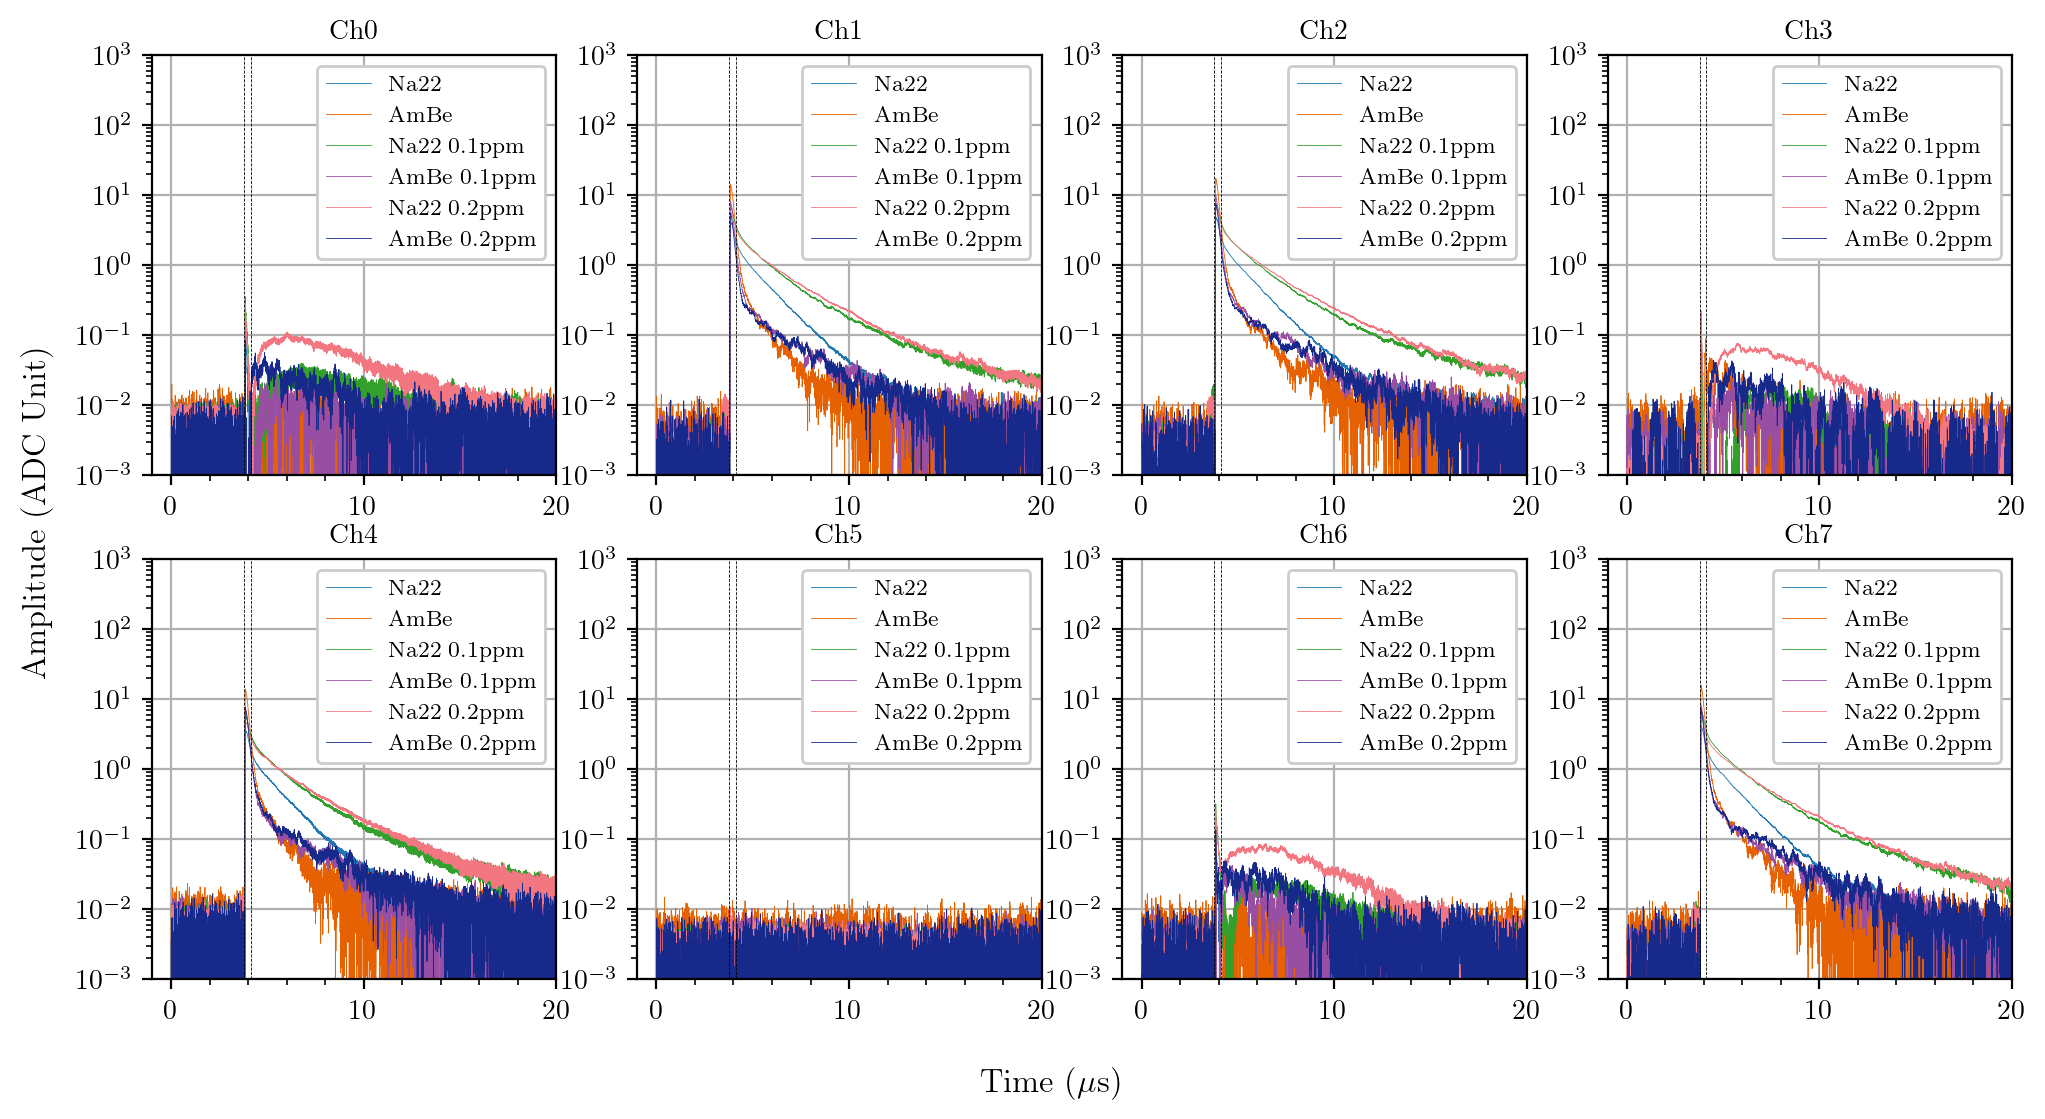

In [45]:
# Make plots for all datasets
# Average LAr scintillation waveform
t_trig = 3.82
ylims = (1e-3,1e3)
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, c in enumerate(cond):
        print(f'{c} ch{ch} {data_scint[k][ch]["n_scint_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_scint[k][ch]['time'],
            data_scint[k][ch]['avg_scint_wf'],
            label=f'{c}', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right',fontsize=8)
    axs[j//4, j%4].set_xlim(-1, 20)
    axs[j//4, j%4].set_ylim(*ylims)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
    axs[j//4, j%4].plot([t_trig-10*0.004]*2, ylims, 'k--',linewidth=0.3)
    axs[j//4, j%4].plot([t_trig+0.3]*2, ylims, 'k--',linewidth=0.3)
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [46]:
# Deconvolution channel by channel
for i, f in enumerate(files):
    for j, ch in enumerate(channels):
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch_old[ch]]['n_spe_wfs']>0:
            dt = data_spe[ch_old[ch]]['time'][1]-data_spe[ch_old[ch]]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[ch_old[ch]]['pars'][3]/dt))) for freq in data_spe[ch_old[ch]]['frequency']])
            data_scint[i][ch]['deconv'] = ifft(fft(data_scint[i][ch]['avg_scint_wf'])/data_spe[ch_old[ch]]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

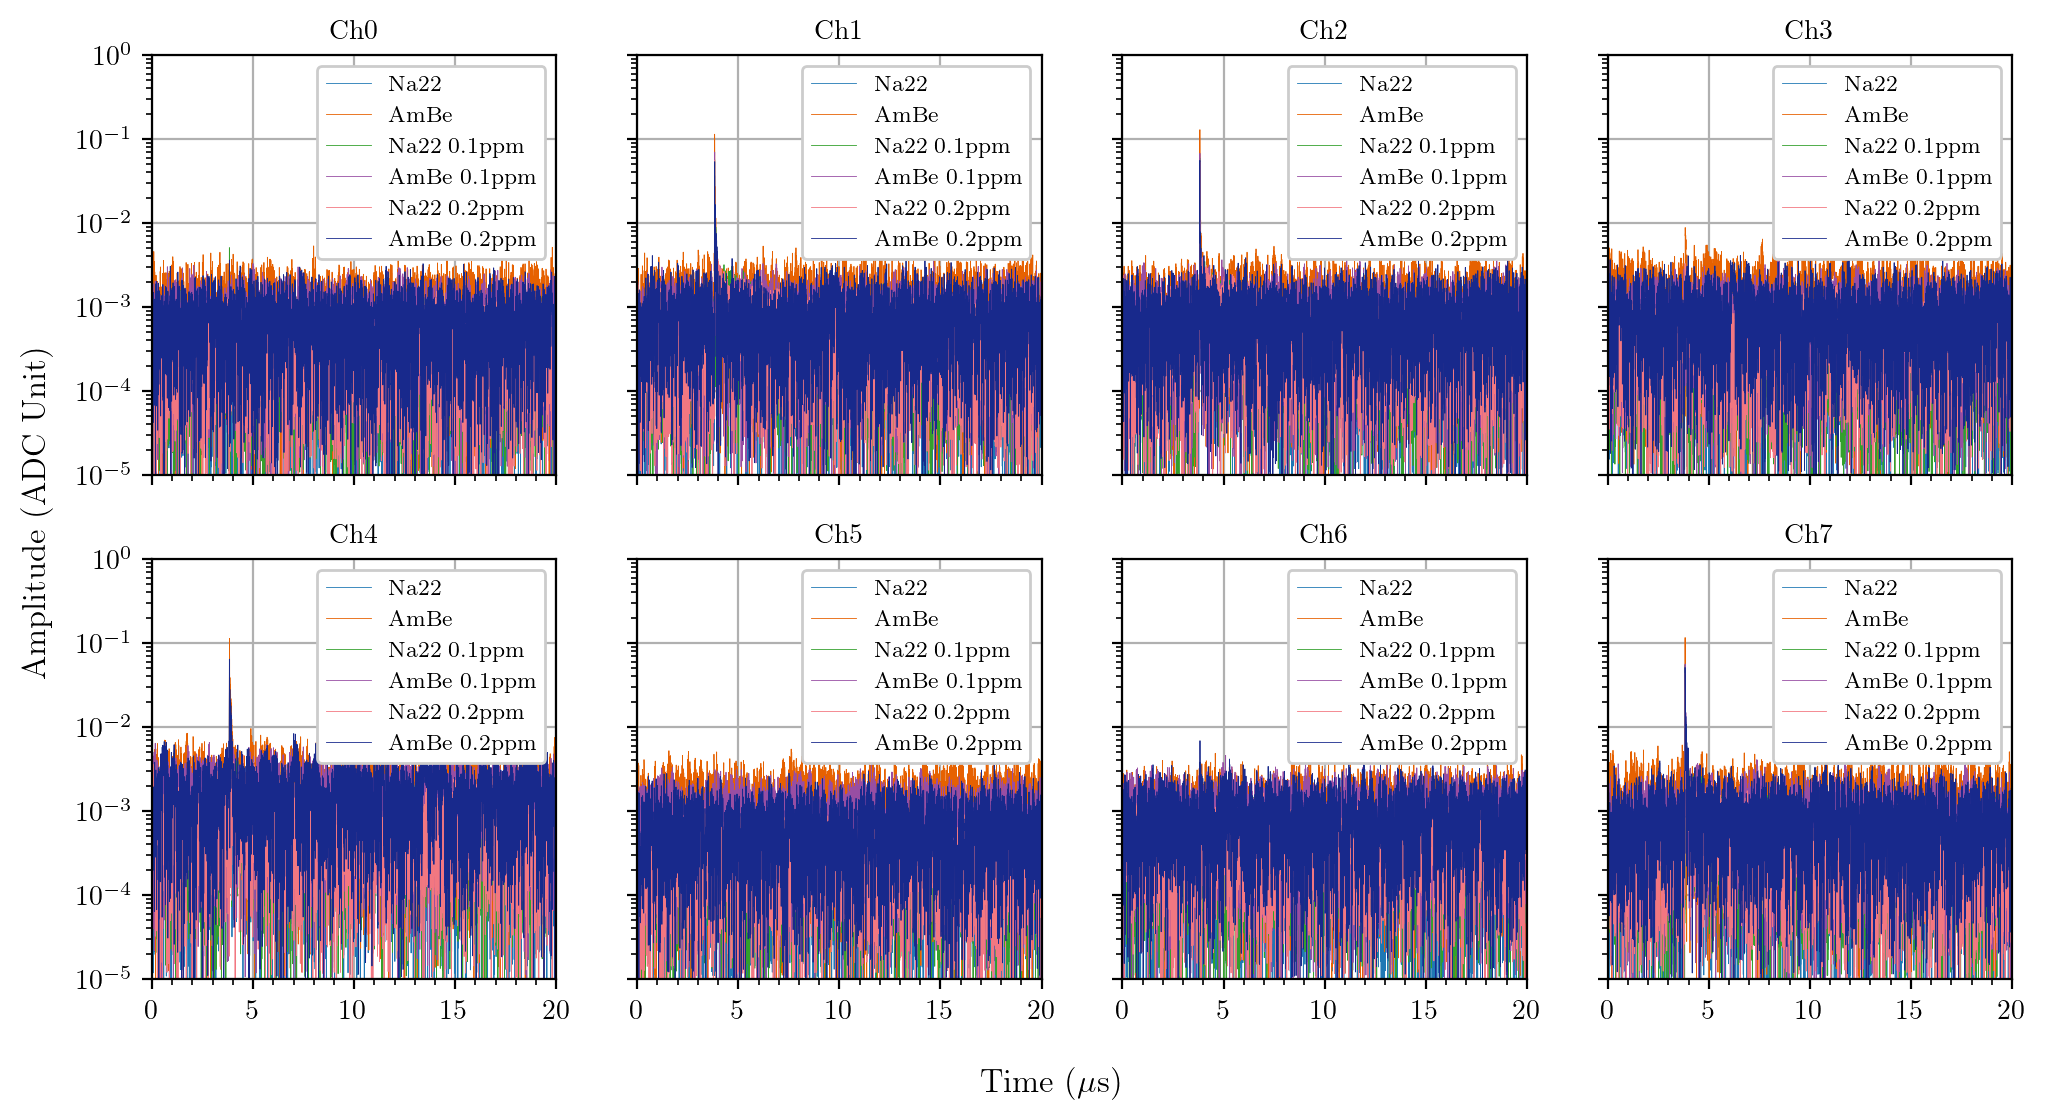

In [47]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, c in enumerate(cond):
        if data_scint[k][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            axs[j//4, j%4].plot(
                data_scint[k][ch]['time'],
                abs(data_scint[k][ch]['deconv']),
                label=f'{c}', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right', fontsize=8)
    axs[j//4, j%4].set_xlim(0, 20)
    axs[j//4, j%4].set_ylim(1e-5, 1e0)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [48]:
# summation
for i,f in enumerate(files):
    data_scint[i][-1] = {'time': data_scint[i][0]['time'], 'sum_wf_nofs': np.zeros(data_scint[i][0]['time'].shape[0]),'sum_wf_fs': np.zeros(data_scint[i][0]['time'].shape[0])}
    for ch in channels_nofs:    
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_nofs'] += data_scint[i][ch]['deconv']
    for ch in channels_fs:
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_fs'] += data_scint[i][ch]['deconv']

In [49]:
# subsampling
nsub = 4
for i,f in enumerate(files):
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_nofs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_nofs'],nsub)
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_fs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_fs'],nsub)

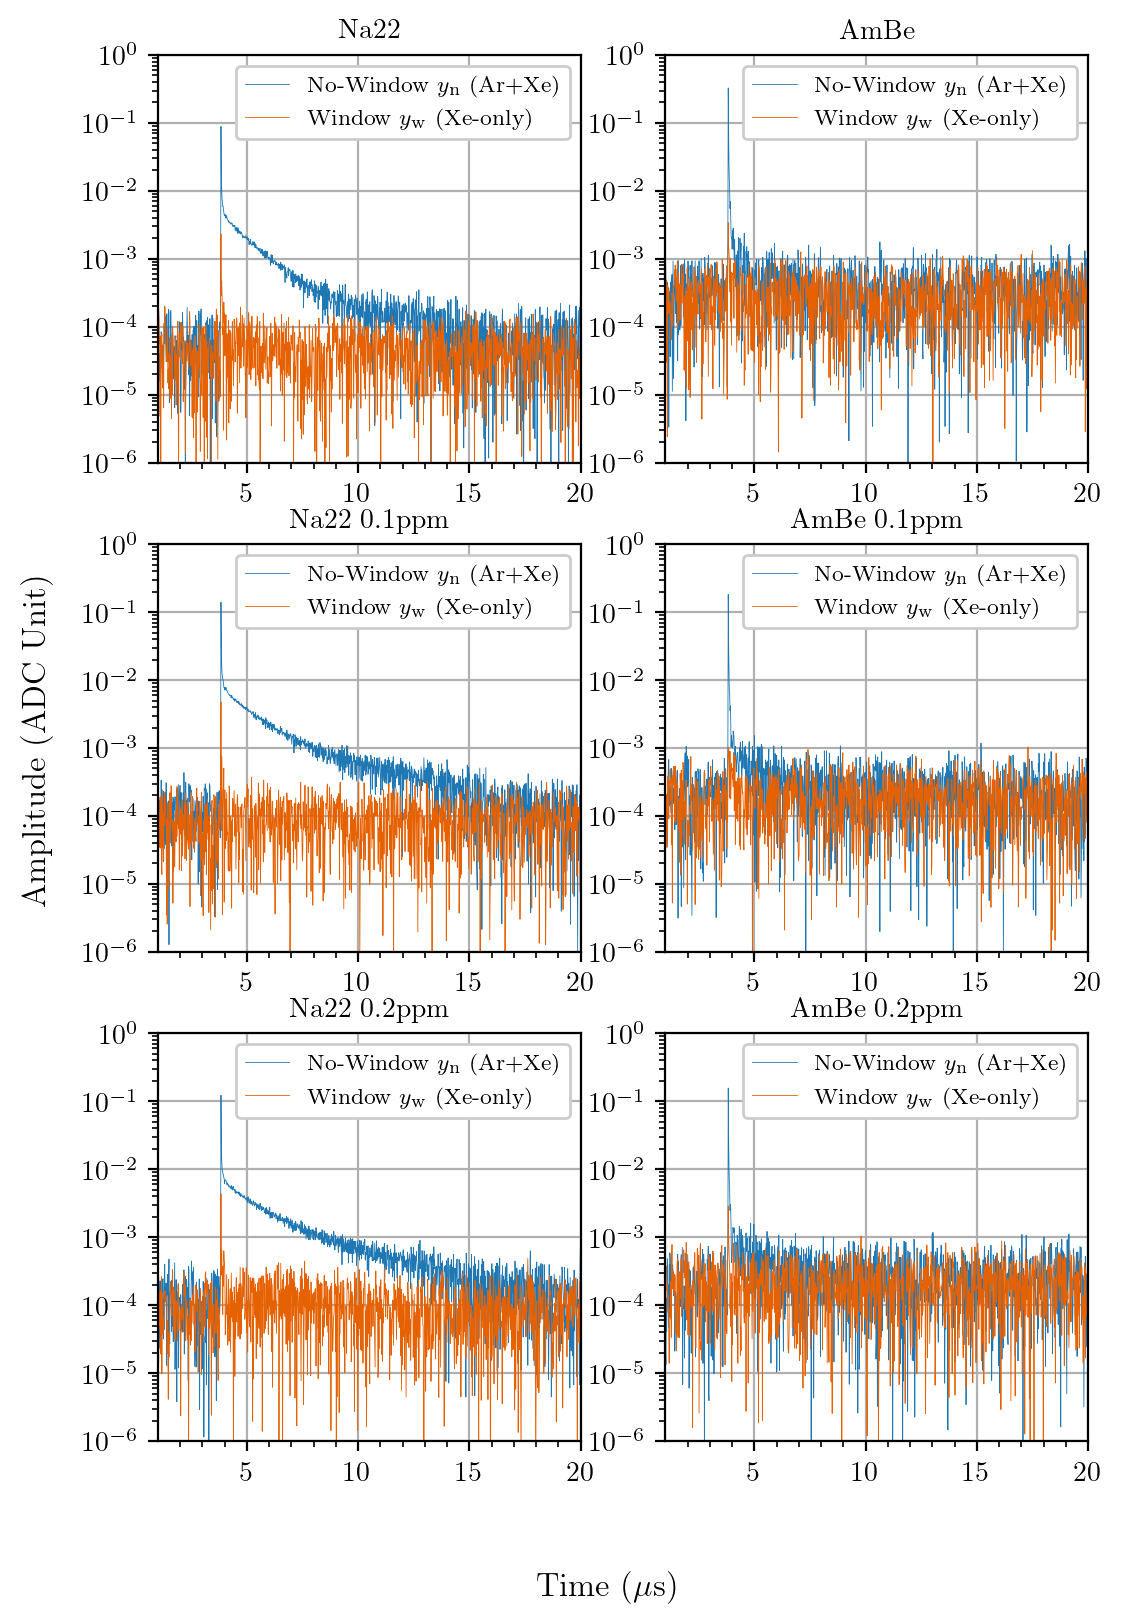

In [52]:
# Make plots for all datasets
# Summed scintillation waveform
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 9)
nofs_total_pe = []
fs_total_pe = []
for i, c in enumerate(cond):
    axs[i//2,i%2].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_nofs']),
                linewidth=0.3,label=r'No-Window $y_{\rm n}$ (Ar+Xe)')
    axs[i//2,i%2].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_fs']),
                linewidth=0.3, label=r'Window $y_{\rm w}$ (Xe-only)')
    axs[i//2,i%2].set_xlim(1, 20)
    axs[i//2,i%2].set_ylim(1e-6, 1e0)
    axs[i//2,i%2].set_yscale('log')
    axs[i//2,i%2].minorticks_on()
    axs[i//2,i%2].grid()
    axs[i//2,i%2].set_title(f'{c}')
    axs[i//2,i%2].legend(loc='upper right')
    nofs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_nofs'])*nsub)
    fs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_fs'])*nsub)
fig.supxlabel(r'Time ($\mu$s)', y=0.02)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.01)
nofs_total_pe = np.array(nofs_total_pe)
fs_total_pe = np.array(fs_total_pe)

In [59]:
# Fit SPE average waveform
data_sub = {}
t_trig = 3.82
for i,c in enumerate(cond):
    if 'AmBe' not in c and data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        pretrg = 3.5 #us
        # simple exponential fit to windowless
        fit_range = [4.5,8.2] #us
        # windowed + simple exponential fit to windowless
        # fit_range = [6.35,10] #us
        err = np.std(data_scint[i][-1]['sum_wf_sub_nofs'][data_scint[i][-1]['time_sub']<pretrg])
        
        # simple exponential fit to windowless
        # range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
        # popt,pcov = curve_fit(
        #     template3,
        #     data_scint[i][-1]['time_sub'][range_arr], 
        #     data_scint[i][-1]['sum_wf_sub_nofs'][range_arr], 
        #     p0=[100,1], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        
        # windowed + simple exponential fit to windowless
        ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'],data_scint[i][-1]['sum_wf_sub_fs']/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub), t_trig=t_trig)
        popt, pcov = ar_xe_pulse_fit.fit_to_data(data_scint[i][-1]['sum_wf_sub_nofs'],sigma=err*np.ones_like(data_scint[i][-1]['time_sub']),x0=[50,0.6,30],fit_range=fit_range)
        
        data_scint[i][-1]['pars'] = popt
        data_scint[i][-1]['cov'] = pcov
        data_scint[i][-1]['pars_err'] = np.array([func.error_distance(df=2, sigma=1)*pcov[j,j]**0.5 for j in range(len(popt))])
        data_scint[i][-1]['fit_range'] = fit_range
        
        # windowed + simple exponential fit to windowless
        print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us A_Xe = {popt[2]:.3f}+/-{data_scint[i][-1]["pars_err"][2]:.3f}')

        # simple exponential fit to windowless
        # print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us')
        

2024-05-07 12:38:58 A=1.65+/-0.01 tau=1.607+/-0.024us A_Xe = 0.000+/-0.003
2024-05-14 15:28:38 A=3.38+/-0.03 tau=2.038+/-0.033us A_Xe = 0.013+/-0.007
2024-05-16 17:35:24 A=3.48+/-0.04 tau=2.316+/-0.047us A_Xe = 0.048+/-0.027


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

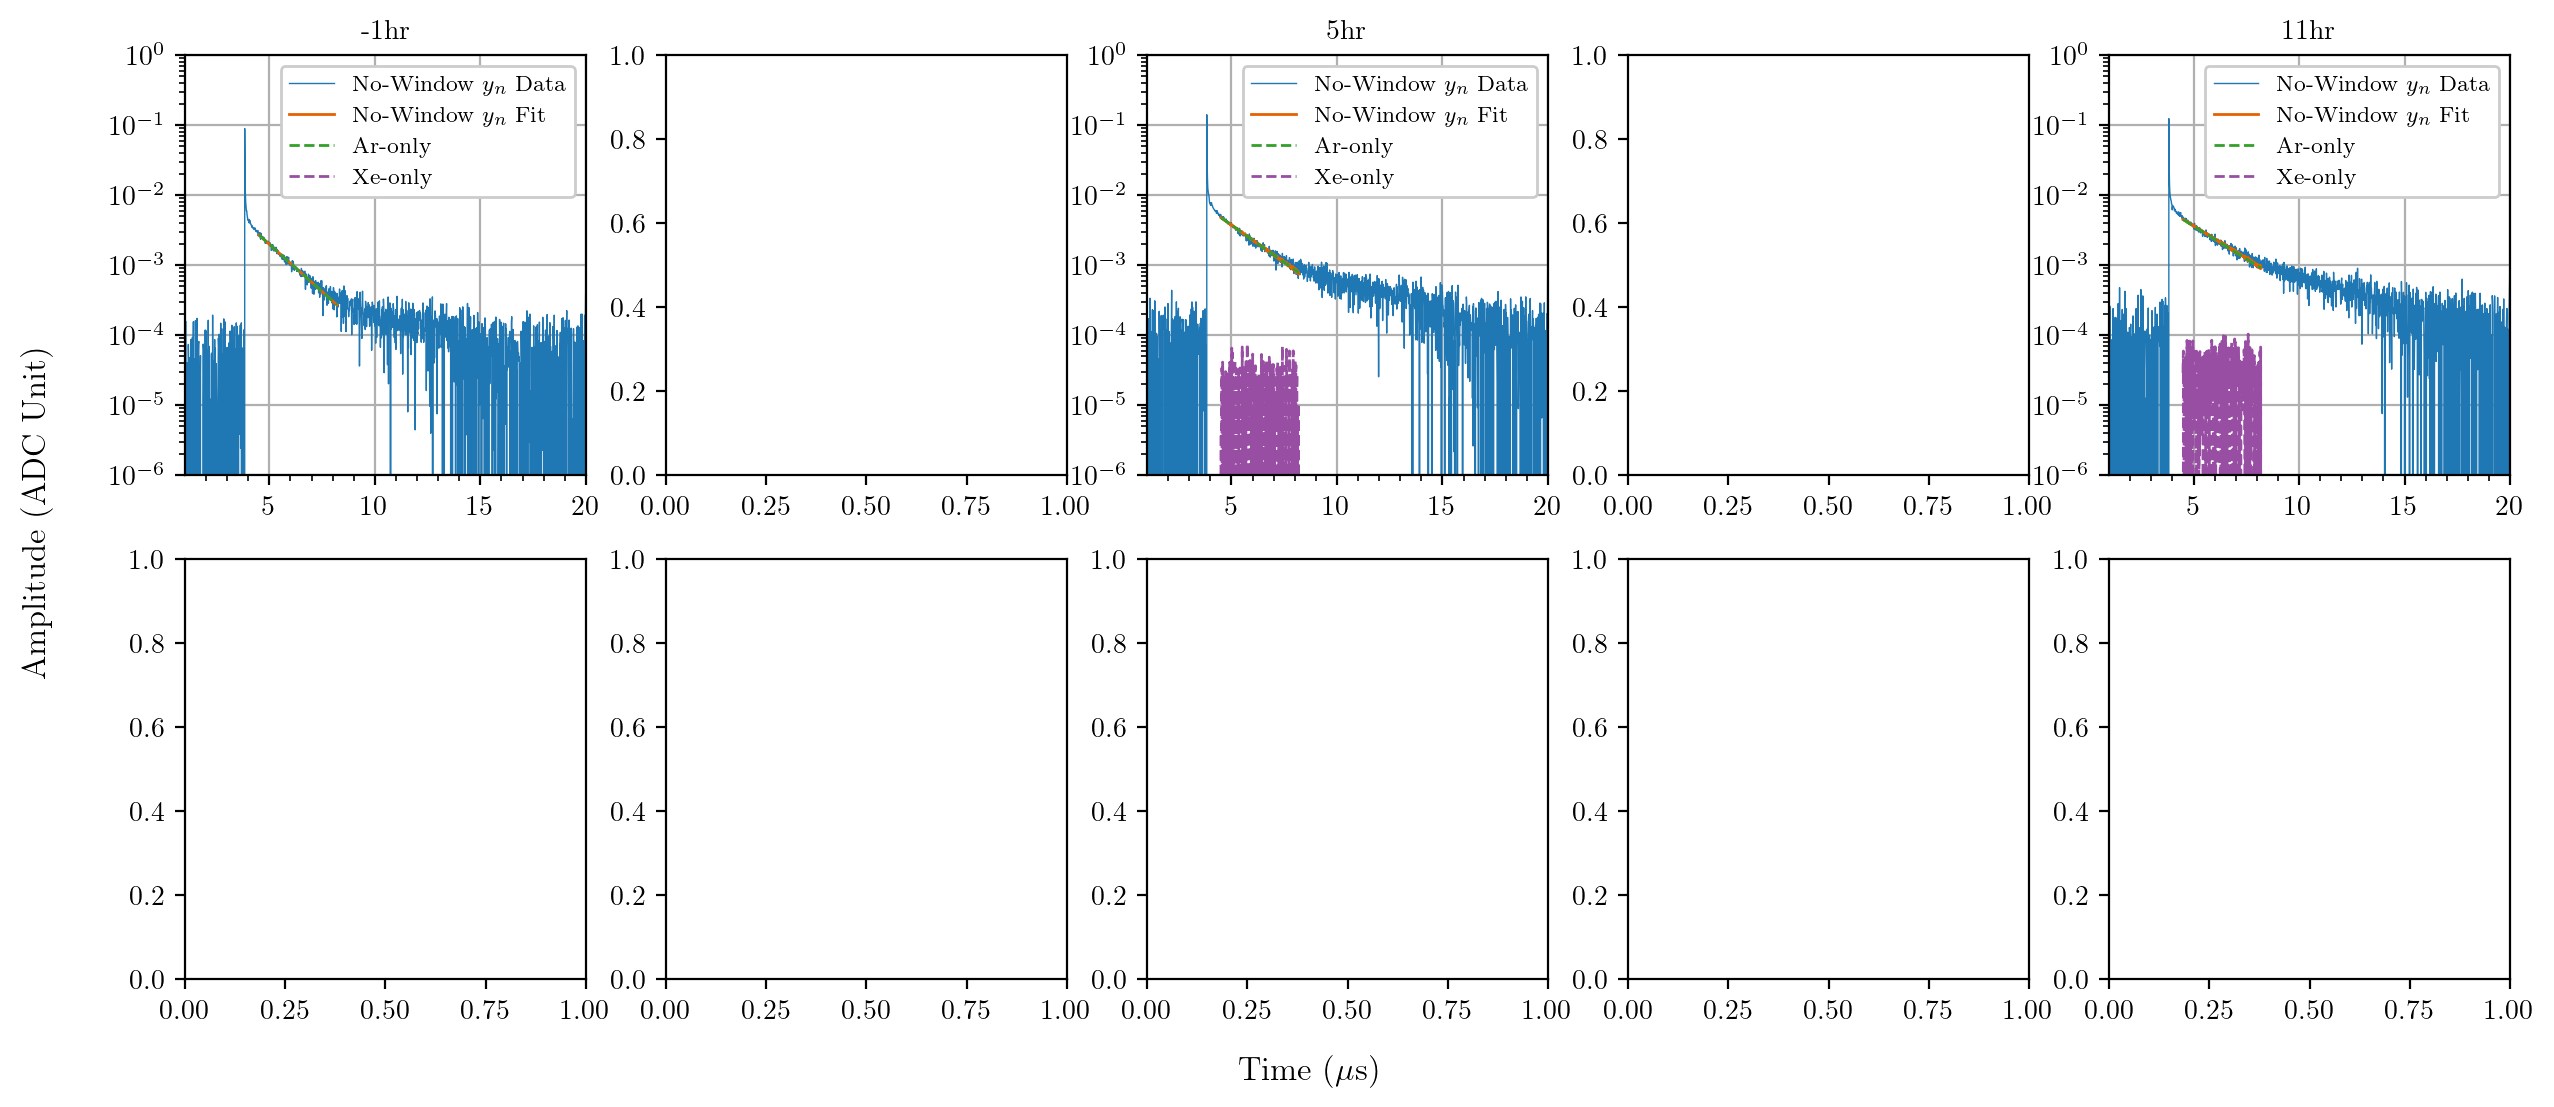

In [69]:
# Make plots for all datasets
nrows = max(2,(len(files)+4)//5)
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, c in enumerate(cond):
    if 'AmBe' not in c and data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'],
            data_scint[i][-1]['sum_wf_sub_nofs'],
            label=r'No-Window $y_n$ Data', color='C0', linewidth=0.5)
        mask = (data_scint[i][-1]['time_sub']>data_scint[i][-1]['fit_range'][0]) & (data_scint[i][-1]['time_sub']<data_scint[i][-1]['fit_range'][1])
        
        # simple exponential fit to windowless
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     template3(data_scint[i][-1]['time_sub'][mask], *data_scint[i][-1]['pars']),
        #     label=r'fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='r', linestyle='--', linewidth=1)
        
        # windowed + simple exponential fit to windowless
        ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'][mask],data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub),t_trig=t_trig)
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars']),
            label=r'No-Window $y_n$ Fit', color='C1', linestyle='-', linewidth=1)
            # label=r'No FS fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='C1', linestyle='-', linewidth=1)
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars'][:-1], a_xe=0),
            label=r'Ar-only', color='C2', linestyle='--', linewidth=1)
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            data_scint[i][-1]['pars'][-1]*data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub,
            label=r'Xe-only', color='C3', linestyle='--', linewidth=1)
        
        axs[i//5, i%5].legend(loc='upper right',ncol=1)
        axs[i//5, i%5].set_xlim(1, 20)
        axs[i//5, i%5].set_ylim(1e-6, 1e0)
        axs[i//5, i%5].set_yscale('log')
        axs[i//5, i%5].minorticks_on()
        axs[i//5, i%5].grid()
        axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
        # axs[i//5, i%5].set_title(f'{hr_from_getter[i]:.0f}hr')
fig.supxlabel(r'Time ($\mu$s)', y=0.02)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Save triplet lifetime vs Xe concentration to an h5 file

In [77]:
store_out = pd.HDFStore('data/tau_Xe_liq7.h5')
xe = np.array([0, 0.1, 0.2])
xe_err = xe*0.3
tau = [data_scint[i][-1]['pars'][1] for i in range(len(cond)) if 'Na22' in cond[i]]
tau_err = [data_scint[i][-1]['pars_err'][1] for i in range(len(cond)) if 'Na22' in cond[i]]
df = pd.DataFrame({'Xe [ppm]':xe,'Xe err [ppm]':xe_err,'Tau [us]':tau,'Tau err [us]':tau_err})
store_out.put('liq7',df)
store_out.close()

# Read Liq6 and Liq7 Tau vs Xe concentration

In [93]:
f6 = pd.HDFStore('data/tau_Xe_liq6.h5')
df6 = f6.get('liq6').iloc[1:,:]
df6

Xe [ppm]  Xe err [ppm]  Tau [us]  Tau err [us]
1       2.7          0.54  1.155389      0.034039
2       5.0          1.00  0.662754      0.031898
3      10.0          2.00  0.314795      0.055316
4      20.0          4.00  0.169672      0.074695
5      40.0          8.00  0.112440      0.040247

In [94]:
f7 = pd.HDFStore('data/tau_Xe_liq7.h5')
df7 = f7.get('liq7').iloc[1:,:]
df7

Xe [ppm]  Xe err [ppm]  Tau [us]  Tau err [us]
1       0.1          0.03  2.037541      0.033396
2       0.2          0.06  2.316088      0.046564

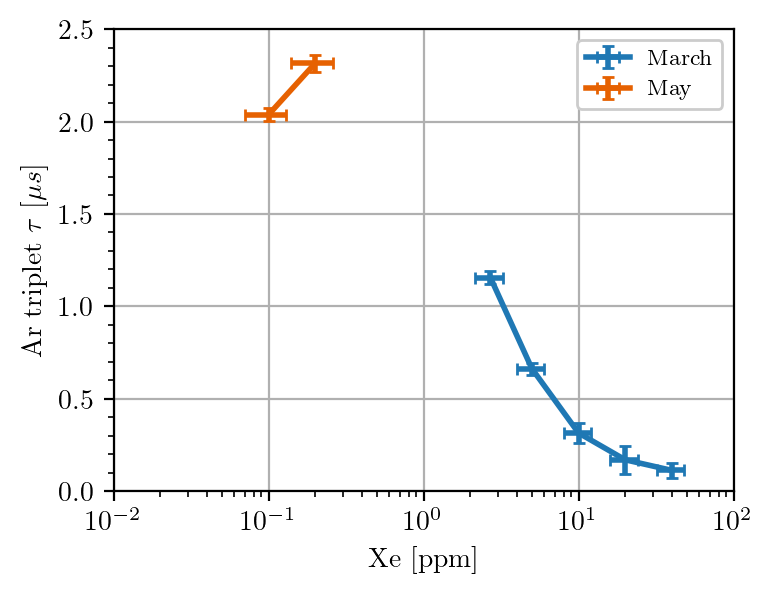

In [95]:

plt.errorbar(df6['Xe [ppm]'],df6['Tau [us]'],xerr=df6['Xe err [ppm]'],yerr=df6['Tau err [us]'],label='March')
plt.errorbar(df7['Xe [ppm]'],df7['Tau [us]'],xerr=df7['Xe err [ppm]'],yerr=df7['Tau err [us]'],label='May')
plt.grid()
plt.minorticks_on()
plt.xlabel('Xe [ppm]')
plt.ylabel(r'Ar triplet $\tau$ [$\mu s$]')
plt.legend(loc='upper right')
plt.xscale('log')